In [1]:
!pip install torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster lxml pandas tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━

In [56]:
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import os
from tqdm import tqdm
import xml.etree.ElementTree as ET

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(" Device in use:", device)

# Verify datasets exist
paths = {
    "player":"/kaggle/input/ssdataset",
    "saliva": "/kaggle/input/salivadata",
    "sweat": "/kaggle/input/sweat-data",
    "urine": "/kaggle/input/urine-data"
}

for name, path in paths.items():
    print(f"{name} path exists:", os.path.exists(path))
    if os.path.exists(path):
        files = os.listdir(path)
        print(f"  📁 Number of files in {name}: {len(files)}")
        print(f"  Example files: {files[:5]}")
    else:
        print(f"  ⚠️ Missing path: {path}")


 Device in use: cpu
player path exists: True
  📁 Number of files in player: 1
  Example files: ['SSD-HIP.csv']
saliva path exists: True
  📁 Number of files in saliva: 1
  Example files: ['saliva_metabolites.xml']
sweat path exists: True
  📁 Number of files in sweat: 1
  Example files: ['sweat_metabolites.xml']
urine path exists: True
  📁 Number of files in urine: 1
  Example files: ['urine_metabolites.xml']


In [57]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_biomarker_xml(file_path, tissue_type):
    """
    Parse HMDB-like XML file to extract biomarker information
    """
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    metabolites = []
    ns = {'hmdb': 'http://www.hmdb.ca'}
    
    for met in root.findall('hmdb:metabolite', ns):
        name = met.find('hmdb:name', ns)
        formula = met.find('hmdb:chemical_formula', ns)
        mw = met.find('hmdb:average_molecular_weight', ns)

        try:
            mw_val = float(mw.text) if mw is not None and mw.text else None
        except ValueError:
            mw_val = None

        metabolites.append({
            'name': name.text if name is not None else None,
            'formula': formula.text if formula is not None else None,
            'mw': mw_val,
            'tissue': tissue_type
        })
    
    return pd.DataFrame(metabolites)

# Parse the three biomarker XML files
saliva_df = parse_biomarker_xml("/kaggle/input/salivadata/saliva_metabolites.xml", "saliva")
sweat_df = parse_biomarker_xml("/kaggle/input/sweat-data/sweat_metabolites.xml", "sweat")
urine_df = parse_biomarker_xml("/kaggle/input/urine-data/urine_metabolites.xml", "urine")

# Display summary
print(" Saliva biomarkers:", saliva_df.shape)
print(" Sweat biomarkers:", sweat_df.shape)
print(" Urine biomarkers:", urine_df.shape)

#  combine all tissues
combined_df = pd.concat([saliva_df, sweat_df, urine_df], ignore_index=True)
print(" Combined Biomarker DataFrame shape:", combined_df.shape)

combined_df.head()


 Saliva biomarkers: (1239, 4)
 Sweat biomarkers: (91, 4)
 Urine biomarkers: (4692, 4)
 Combined Biomarker DataFrame shape: (6022, 4)


name    formula        mw  tissue
0      1-Methylhistidine  C7H11N3O2  169.1811  saliva
1     2-Ketobutyric acid     C4H6O3  102.0886  saliva
2  2-Hydroxybutyric acid     C4H8O3  104.1050  saliva
3  3-Hydroxybutyric acid     C4H8O3  104.1045  saliva
4       4-Pyridoxic acid    C8H9NO4  183.1614  saliva

In [58]:
# Cell 2: Inspect first few rows of each dataframe
print("Saliva sample:")
display(saliva_df.head())

print("\nSweat sample:")
display(sweat_df.head())

print("\nUrine sample:")
display(urine_df.head())

# Optionally, get column names
print("\nColumns in saliva:", saliva_df.columns.tolist())
print("Columns in sweat:", sweat_df.columns.tolist())
print("Columns in urine:", urine_df.columns.tolist())


Saliva sample:


name    formula        mw  tissue
0      1-Methylhistidine  C7H11N3O2  169.1811  saliva
1     2-Ketobutyric acid     C4H6O3  102.0886  saliva
2  2-Hydroxybutyric acid     C4H8O3  104.1050  saliva
3  3-Hydroxybutyric acid     C4H8O3  104.1045  saliva
4       4-Pyridoxic acid    C8H9NO4  183.1614  saliva


Sweat sample:


name   formula        mw tissue
0  2-Hydroxybutyric acid    C4H8O3  104.1050  sweat
1               Creatine  C4H9N3O2  131.1332  sweat
2      cis-Aconitic acid    C6H6O6  174.1082  sweat
3          Dimethylamine     C2H7N   45.0837  sweat
4            Citric acid    C6H8O7  192.1235  sweat


Urine sample:


name    formula        mw tissue
0      1-Methylhistidine  C7H11N3O2  169.1811  urine
1     1,3-Diaminopropane    C3H10N2   74.1249  urine
2     2-Ketobutyric acid     C4H6O3  102.0886  urine
3  2-Hydroxybutyric acid     C4H8O3  104.1050  urine
4       2-Methoxyestrone   C19H24O3  300.3921  urine


Columns in saliva: ['name', 'formula', 'mw', 'tissue']
Columns in sweat: ['name', 'formula', 'mw', 'tissue']
Columns in urine: ['name', 'formula', 'mw', 'tissue']


In [59]:
# --- List files in the SSD dataset folder ---
import os

dataset_path = '/kaggle/input/ssdataset'
print("Files in SSD dataset folder:")
print(os.listdir(dataset_path))


Files in SSD dataset folder:
['SSD-HIP.csv']


In [60]:
# --- Load SSD-HIP dataset ---
ssd_df = pd.read_csv('/kaggle/input/ssdataset/SSD-HIP.csv')

# Inspect the dataset
print("SSD-HIP shape:", ssd_df.shape)
ssd_df.head()


SSD-HIP shape: (120000, 17)


rms_feat  integral_signal  zero_crossings  waveform_length  \
0  0.127982         1.742839            10.0        11.168069   
1  0.111467         1.591829             9.0        10.778058   
2  0.085457         1.211304             9.0         8.211505   
3  0.092287         1.317333             9.0         8.844116   
4  0.107735         1.535709             9.0        10.410482   

   auto_regressive_coefficients  temporal_moment  avg_amp_change  min_value  \
0                      0.100417         0.014920        0.055840  -0.127310   
1                      0.116953         0.014686        0.052321  -0.118846   
2                      0.117578         0.006056        0.039862  -0.090266   
3                      0.118016         0.007840        0.042933  -0.096818   
4                      0.117408         0.013034        0.050292  -0.114825   

   max_value  variance  log_detector  linear_env   v_order  modified_mav  \
0   0.078495  0.004633      0.030966    0.615198 -0.014908      0.065112   
1   0.081719  0.004884      0.031792    0.651916 -0.014675      0.068227   
2   0.062453  0.002785      0.024771    0.650459 -0.006051      0.051476   
3   0.068157  0.003276      0.026320    0.658553 -0.007834      0.056409   
4   0.078692  0.004546      0.030752    0.651277 -0.013025      0.065631   

   skewness  fourier_series  status  
0 -3.163882        0.000785       0  
1 -2.966115        0.000766       0  
2 -2.895481        0.000579       0  
3 -2.904709        0.000624       0  
4 -2.961475        0.000737       0

In [61]:
# --- Load SSD-HIP dataset ---
ssd_df = pd.read_csv('/kaggle/input/ssdataset/SSD-HIP.csv')

# Inspect shape and columns
print("SSD-HIP shape:", ssd_df.shape)
print("Columns:", ssd_df.columns.tolist())

# Preview first 5 rows
ssd_df.head()

# Check target class distribution
class_counts = ssd_df['status'].value_counts()
print("Target class distribution:\n", class_counts)


SSD-HIP shape: (120000, 17)
Columns: ['rms_feat', 'integral_signal', 'zero_crossings', 'waveform_length', 'auto_regressive_coefficients', 'temporal_moment', 'avg_amp_change', 'min_value', 'max_value', 'variance', 'log_detector', 'linear_env', 'v_order', 'modified_mav', 'skewness', 'fourier_series', 'status']
Target class distribution:
 status
0    60000
1    60000
Name: count, dtype: int64


In [62]:
# Basic info and preview
print("Shape of combined_df:", combined_df.shape)
print("\nColumn names:", combined_df.columns.tolist())
print("\nData types:")
print(combined_df.dtypes)

# Preview first few rows
combined_df.head()


Shape of combined_df: (6022, 4)

Column names: ['name', 'formula', 'mw', 'tissue']

Data types:
name        object
formula     object
mw         float64
tissue      object
dtype: object


name    formula        mw  tissue
0      1-Methylhistidine  C7H11N3O2  169.1811  saliva
1     2-Ketobutyric acid     C4H6O3  102.0886  saliva
2  2-Hydroxybutyric acid     C4H8O3  104.1050  saliva
3  3-Hydroxybutyric acid     C4H8O3  104.1045  saliva
4       4-Pyridoxic acid    C8H9NO4  183.1614  saliva

In [63]:
# Check missing values
missing = combined_df.isnull().sum()
missing_percent = (missing / len(combined_df)) * 100

print("Missing values per column:\n", missing)
print("\nPercentage missing:\n", missing_percent)


Missing values per column:
 name       0
formula    0
mw         1
tissue     0
dtype: int64

Percentage missing:
 name       0.000000
formula    0.000000
mw         0.016606
tissue     0.000000
dtype: float64


In [64]:
# Summary stats for molecular weight
mw_stats = combined_df['mw'].describe()
print(mw_stats)


count    6021.000000
mean      384.741896
std       279.148324
min         6.941000
25%       184.146100
50%       298.293400
75%       500.547700
max      6179.373000
Name: mw, dtype: float64



Biomarker count per tissue:
 tissue
urine     4692
saliva    1239
sweat       91
Name: count, dtype: int64


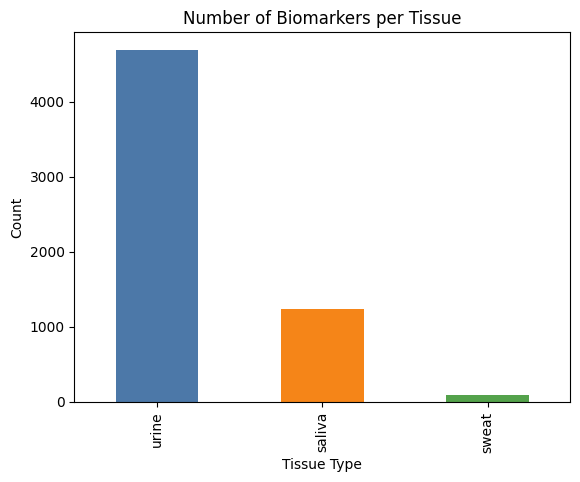

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
# Frequency count by tissue
print("\nBiomarker count per tissue:\n", combined_df['tissue'].value_counts())

# Optional visualization (matplotlib)
import matplotlib.pyplot as plt

combined_df['tissue'].value_counts().plot(
    kind='bar', color=['#4C78A8', '#F58518', '#54A24B']
)
plt.title("Number of Biomarkers per Tissue")
plt.xlabel("Tissue Type")
plt.ylabel("Count")
plt.show()
plt.savefig('/kaggle/working/graph1.png')


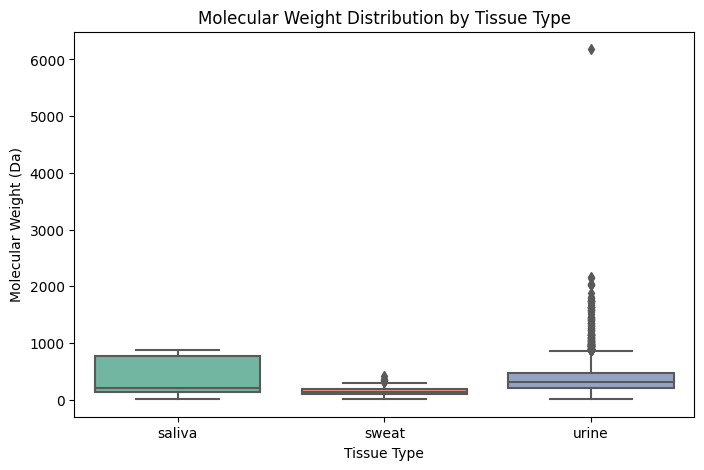

<Figure size 640x480 with 0 Axes>

In [12]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=combined_df, x='tissue', y='mw', palette='Set2')
plt.title("Molecular Weight Distribution by Tissue Type")
plt.xlabel("Tissue Type")
plt.ylabel("Molecular Weight (Da)")
plt.show()
plt.savefig('/kaggle/working/graph2.png')


In [13]:
# Check for duplicates by name
duplicates = combined_df[combined_df.duplicated('name', keep=False)].sort_values('name')
print(f"Number of duplicate metabolite names: {duplicates['name'].nunique()}")
duplicates.head(10)


Number of duplicate metabolite names: 791


name  formula        mw  tissue
2191                   (+)-Limonene   C10H16  136.2340   urine
371                    (+)-Limonene   C10H16  136.2340  saliva
3023  (R)-2,3-Dihydroxy-isovalerate  C5H10O4  134.1305   urine
823   (R)-2,3-Dihydroxy-isovalerate  C5H10O4  134.1305  saliva
987       (S)-2-Methylbutanoic acid  C5H10O2  102.1317  saliva
4620      (S)-2-Methylbutanoic acid  C5H10O2  102.1317   urine
7      (S)-3-Hydroxyisobutyric acid   C4H8O3  104.1045  saliva
1343   (S)-3-Hydroxyisobutyric acid   C4H8O3  104.1045   urine
390                     (S)-Carvone  C10H14O  150.2176  saliva
2251                    (S)-Carvone  C10H14O  150.2176   urine

In [14]:
# Summarize molecular weight per tissue
bio_summary = combined_df.groupby('tissue')['mw'].agg(['mean', 'std', 'min', 'max']).reset_index()
print(bio_summary)


   tissue        mean         std      min        max
0  saliva  384.721633  306.066627   6.9410   882.3267
1   sweat  151.206667   77.133080  18.0153   410.7300
2   urine  389.277563  272.215251   6.9410  6179.3730


In [15]:
bio_summary.columns = ['tissue', 'mw_mean', 'mw_std', 'mw_min', 'mw_max']
print(bio_summary)


   tissue     mw_mean      mw_std   mw_min     mw_max
0  saliva  384.721633  306.066627   6.9410   882.3267
1   sweat  151.206667   77.133080  18.0153   410.7300
2   urine  389.277563  272.215251   6.9410  6179.3730


In [16]:
bio_summary['source_type'] = 'biomarker'
print(bio_summary)


   tissue     mw_mean      mw_std   mw_min     mw_max source_type
0  saliva  384.721633  306.066627   6.9410   882.3267   biomarker
1   sweat  151.206667   77.133080  18.0153   410.7300   biomarker
2   urine  389.277563  272.215251   6.9410  6179.3730   biomarker


In [17]:
# Load the SSD-HIP dataset
import pandas as pd

df_ssd = pd.read_csv("/kaggle/input/ssdataset/SSD-HIP.csv")

# Display shape and first few rows
print("SSD-HIP shape:", df_ssd.shape)
df_ssd.head()


SSD-HIP shape: (120000, 17)


rms_feat  integral_signal  zero_crossings  waveform_length  \
0  0.127982         1.742839            10.0        11.168069   
1  0.111467         1.591829             9.0        10.778058   
2  0.085457         1.211304             9.0         8.211505   
3  0.092287         1.317333             9.0         8.844116   
4  0.107735         1.535709             9.0        10.410482   

   auto_regressive_coefficients  temporal_moment  avg_amp_change  min_value  \
0                      0.100417         0.014920        0.055840  -0.127310   
1                      0.116953         0.014686        0.052321  -0.118846   
2                      0.117578         0.006056        0.039862  -0.090266   
3                      0.118016         0.007840        0.042933  -0.096818   
4                      0.117408         0.013034        0.050292  -0.114825   

   max_value  variance  log_detector  linear_env   v_order  modified_mav  \
0   0.078495  0.004633      0.030966    0.615198 -0.014908      0.065112   
1   0.081719  0.004884      0.031792    0.651916 -0.014675      0.068227   
2   0.062453  0.002785      0.024771    0.650459 -0.006051      0.051476   
3   0.068157  0.003276      0.026320    0.658553 -0.007834      0.056409   
4   0.078692  0.004546      0.030752    0.651277 -0.013025      0.065631   

   skewness  fourier_series  status  
0 -3.163882        0.000785       0  
1 -2.966115        0.000766       0  
2 -2.895481        0.000579       0  
3 -2.904709        0.000624       0  
4 -2.961475        0.000737       0

In [18]:
# Summarize SSD-HIP dataset
ssd_summary = df_ssd.describe().T.reset_index()
ssd_summary = ssd_summary.rename(columns={'index': 'feature'})
ssd_summary['source_type'] = 'SSD-HIP'

print("SSD-HIP summary shape:", ssd_summary.shape)
ssd_summary.head()


SSD-HIP summary shape: (17, 10)


feature     count       mean       std       min  \
0                      rms_feat  120000.0   0.112637  0.039884  0.033273   
1               integral_signal  120000.0   1.555305  0.528396  0.488144   
2                zero_crossings  120000.0  10.444414  0.881173  8.333333   
3               waveform_length  120000.0  10.562790  3.819937  3.284500   
4  auto_regressive_coefficients  120000.0   0.111396  0.007052  0.075660   

         25%        50%        75%        max source_type  
0   0.084291   0.104518   0.139288   0.247540     SSD-HIP  
1   1.172879   1.448280   1.922990   3.372757     SSD-HIP  
2  10.000000  10.333333  11.000000  15.000000     SSD-HIP  
3   7.785440   9.782435  13.108515  23.125939     SSD-HIP  
4   0.107125   0.111424   0.115846   0.132861     SSD-HIP

In [19]:
# Combine biomarker summary with SSD-HIP summary
combined_summary = pd.concat([bio_summary, ssd_summary], ignore_index=True)

print("Combined summary shape:", combined_summary.shape)
combined_summary.head(10)


Combined summary shape: (20, 15)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


tissue     mw_mean      mw_std   mw_min     mw_max source_type  \
0  saliva  384.721633  306.066627   6.9410   882.3267   biomarker   
1   sweat  151.206667   77.133080  18.0153   410.7300   biomarker   
2   urine  389.277563  272.215251   6.9410  6179.3730   biomarker   
3     NaN         NaN         NaN      NaN        NaN     SSD-HIP   
4     NaN         NaN         NaN      NaN        NaN     SSD-HIP   
5     NaN         NaN         NaN      NaN        NaN     SSD-HIP   
6     NaN         NaN         NaN      NaN        NaN     SSD-HIP   
7     NaN         NaN         NaN      NaN        NaN     SSD-HIP   
8     NaN         NaN         NaN      NaN        NaN     SSD-HIP   
9     NaN         NaN         NaN      NaN        NaN     SSD-HIP   

                        feature     count       mean       std       min  \
0                           NaN       NaN        NaN       NaN       NaN   
1                           NaN       NaN        NaN       NaN       NaN   
2                           NaN       NaN        NaN       NaN       NaN   
3                      rms_feat  120000.0   0.112637  0.039884  0.033273   
4               integral_signal  120000.0   1.555305  0.528396  0.488144   
5                zero_crossings  120000.0  10.444414  0.881173  8.333333   
6               waveform_length  120000.0  10.562790  3.819937  3.284500   
7  auto_regressive_coefficients  120000.0   0.111396  0.007052  0.075660   
8               temporal_moment  120000.0   0.017973  0.022318  0.000255   
9                avg_amp_change  120000.0   0.051357  0.018581  0.016014   

         25%        50%        75%        max  
0        NaN        NaN        NaN        NaN  
1        NaN        NaN        NaN        NaN  
2        NaN        NaN        NaN        NaN  
3   0.084291   0.104518   0.139288   0.247540  
4   1.172879   1.448280   1.922990   3.372757  
5  10.000000  10.333333  11.000000  15.000000  
6   7.785440   9.782435  13.108515  23.125939  
7   0.107125   0.111424   0.115846   0.132861  
8   0.004213   0.008832   0.023065   0.177698  
9   0.037832   0.047543   0.063753   0.113826

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

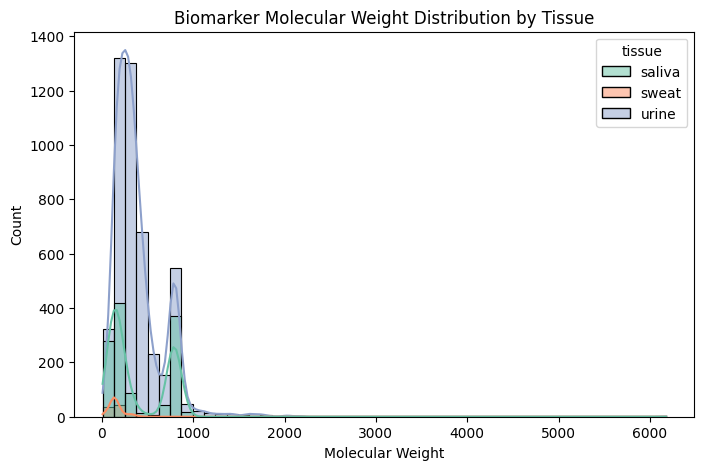

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Figure size 640x480 with 0 Axes>

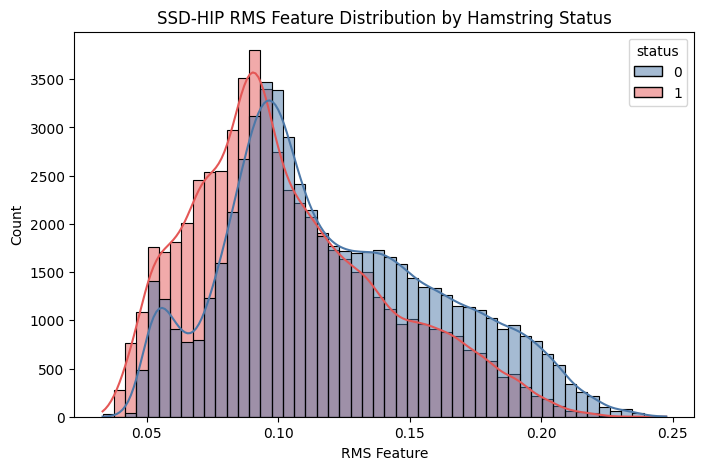

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Biomarker molecular weight distribution ---
plt.figure(figsize=(8,5))
sns.histplot(data=combined_df, x='mw', hue='tissue', bins=50, kde=True, palette='Set2')
plt.title('Biomarker Molecular Weight Distribution by Tissue')
plt.xlabel('Molecular Weight')
plt.ylabel('Count')
plt.show()
plt.savefig('/kaggle/working/graph3.png')

# --- SSD-HIP RMS feature distribution by status ---
plt.figure(figsize=(8,5))
sns.histplot(data=df_ssd, x='rms_feat', hue='status', bins=50, kde=True, palette=['#4C78A8','#E45756'])
plt.title('SSD-HIP RMS Feature Distribution by Hamstring Status')
plt.xlabel('RMS Feature')
plt.ylabel('Count')
plt.show()
plt.savefig('/kaggle/working/graph4.png')


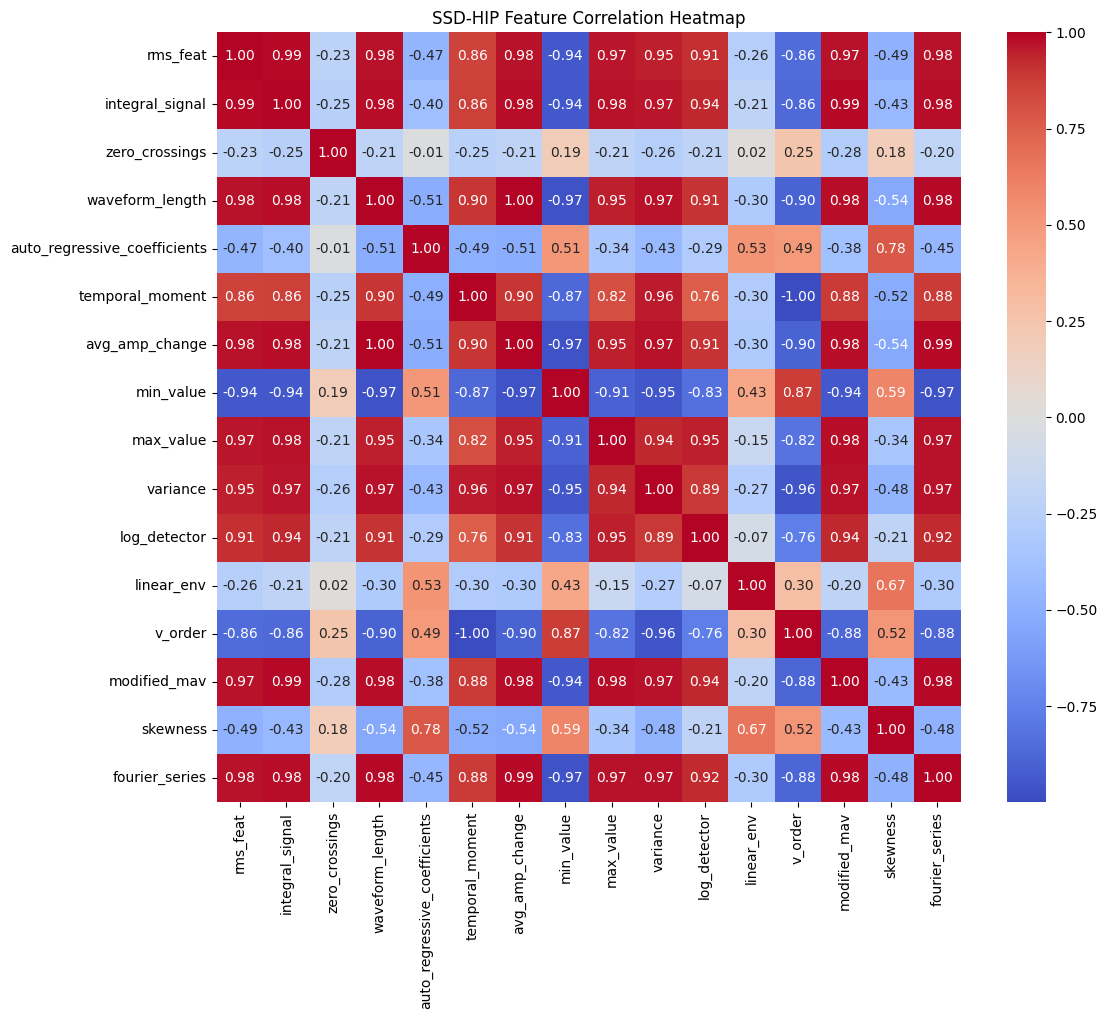

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix for SSD-HIP numeric features
ssd_corr = df_ssd.drop(columns=['status']).corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(ssd_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('SSD-HIP Feature Correlation Heatmap')
plt.show()
plt.savefig('/kaggle/working/graph5.png')


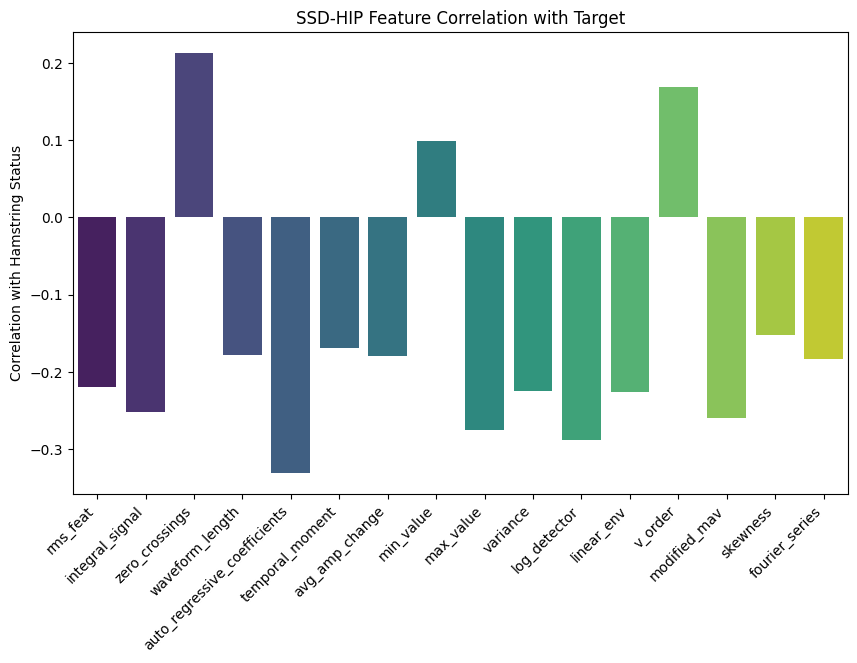

zero_crossings                  0.212688
v_order                         0.168877
min_value                       0.098859
skewness                       -0.152571
temporal_moment                -0.168884
waveform_length                -0.178580
avg_amp_change                 -0.178867
fourier_series                 -0.183863
rms_feat                       -0.219278
variance                       -0.224387
linear_env                     -0.226631
integral_signal                -0.252180
modified_mav                   -0.260042
max_value                      -0.274713
log_detector                   -0.288243
auto_regressive_coefficients   -0.330867
Name: status, dtype: float64


<Figure size 640x480 with 0 Axes>

In [22]:
# Compute correlation with target
target_corr = df_ssd.corr()['status'].drop('status')  # exclude self-correlation

# Plot bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=target_corr.index, y=target_corr.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with Hamstring Status')
plt.title('SSD-HIP Feature Correlation with Target')
plt.show()
plt.savefig('/kaggle/working/graph6.png')

# Optional: display correlations
print(target_corr.sort_values(ascending=False))


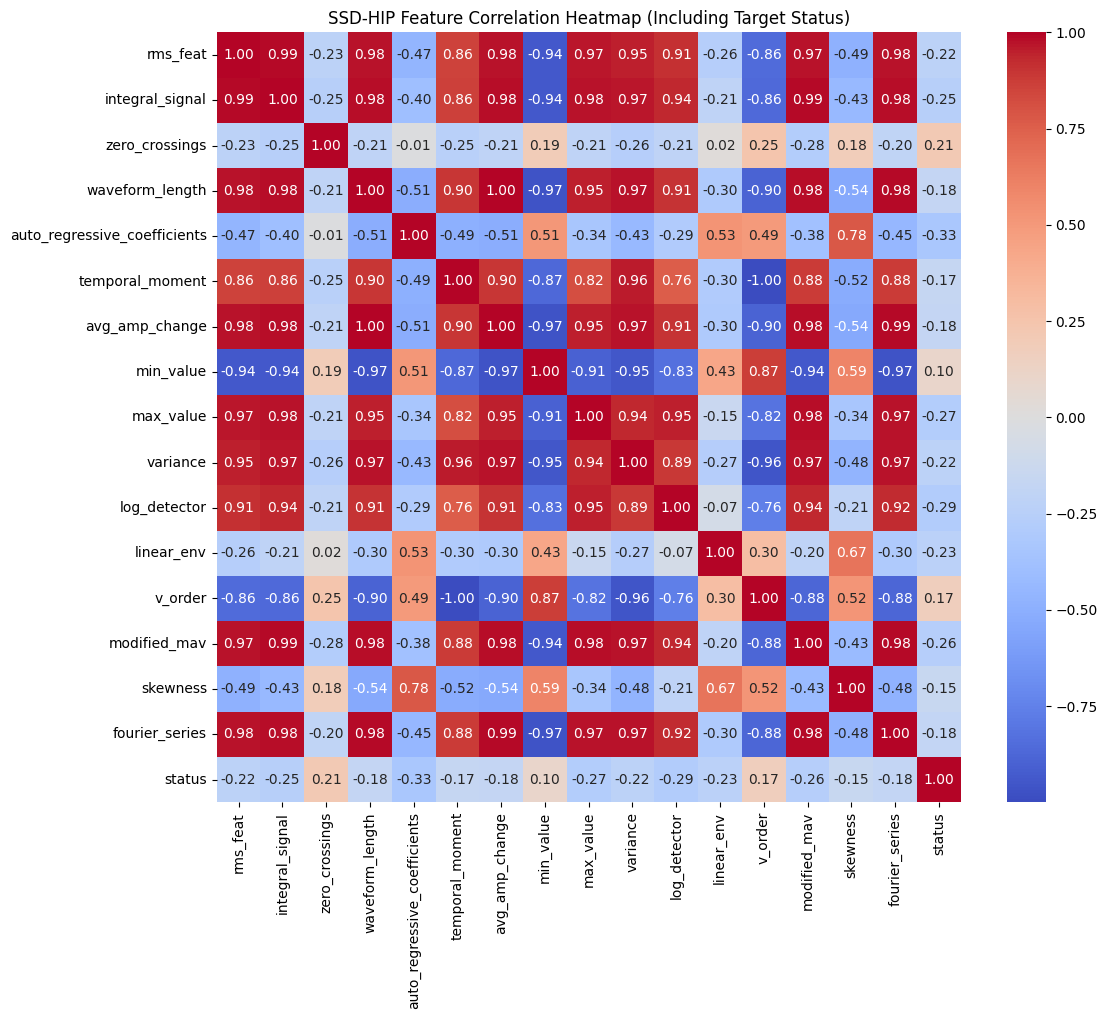

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix for SSD-HIP features including the target
corr_matrix = df_ssd.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("SSD-HIP Feature Correlation Heatmap (Including Target Status)")
plt.show()
plt.savefig('/kaggle/working/graph7.png')


In [24]:
# --- Step 1: Prepare biomarker data ---
# Encode tissue type as categorical numeric values
biomarker_model_df = combined_df[['mw', 'tissue']].copy()
biomarker_model_df = pd.get_dummies(biomarker_model_df, columns=['tissue'], drop_first=True)

# Biomarker target placeholder (if not available, can be set to NaN or a proxy)
biomarker_model_df['status'] = 0  # or any label if you have it

# --- Step 2: Prepare SSD-HIP data ---
ssd_model_df = df_ssd.copy()  # Includes 'status' already

# --- Step 3: Align columns for concatenation ---
# Make sure both datasets have the same columns
for col in ssd_model_df.columns:
    if col not in biomarker_model_df.columns:
        biomarker_model_df[col] = 0  # Fill missing columns with 0

for col in biomarker_model_df.columns:
    if col not in ssd_model_df.columns:
        ssd_model_df[col] = 0  # Fill missing columns with 0

# --- Step 4: Combine the raw datasets ---
combined_model_df = pd.concat([biomarker_model_df, ssd_model_df], ignore_index=True)

print("Combined model dataset shape:", combined_model_df.shape)
combined_model_df.head()


Combined model dataset shape: (126022, 20)


mw  tissue_sweat  tissue_urine  status  rms_feat  integral_signal  \
0  169.1811             0             0       0       0.0              0.0   
1  102.0886             0             0       0       0.0              0.0   
2  104.1050             0             0       0       0.0              0.0   
3  104.1045             0             0       0       0.0              0.0   
4  183.1614             0             0       0       0.0              0.0   

   zero_crossings  waveform_length  auto_regressive_coefficients  \
0             0.0              0.0                           0.0   
1             0.0              0.0                           0.0   
2             0.0              0.0                           0.0   
3             0.0              0.0                           0.0   
4             0.0              0.0                           0.0   

   temporal_moment  avg_amp_change  min_value  max_value  variance  \
0              0.0             0.0        0.0        0.0       0.0   
1              0.0             0.0        0.0        0.0       0.0   
2              0.0             0.0        0.0        0.0       0.0   
3              0.0             0.0        0.0        0.0       0.0   
4              0.0             0.0        0.0        0.0       0.0   

   log_detector  linear_env  v_order  modified_mav  skewness  fourier_series  
0           0.0         0.0      0.0           0.0       0.0             0.0  
1           0.0         0.0      0.0           0.0       0.0             0.0  
2           0.0         0.0      0.0           0.0       0.0             0.0  
3           0.0         0.0      0.0           0.0       0.0             0.0  
4           0.0         0.0      0.0           0.0       0.0             0.0

In [25]:
# --- Step 1: Check for missing values ---
missing_counts = combined_model_df.isna().sum()
print("Missing values per column:\n", missing_counts)

# --- Step 2: Basic missing value handling ---
# For numeric columns, fill missing values with 0 (we already have 0 for SSD-HIP in biomarker rows)
combined_model_df.fillna(0, inplace=True)

# --- Step 3: Check class imbalance ---
status_counts = combined_model_df['status'].value_counts()
print("\nClass distribution:\n", status_counts)

# --- Step 4: Handle imbalance (optional for model training) ---
# Example: Using oversampling of minority class
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = combined_model_df[combined_model_df.status == 0]
df_minority = combined_model_df[combined_model_df.status == 1]

# Oversample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # match majority
                                 random_state=42)  # reproducible results

# Combine to create balanced dataset
balanced_model_df = pd.concat([df_majority, df_minority_upsampled])
print("\nBalanced dataset shape:", balanced_model_df.shape)
print("Balanced class distribution:\n", balanced_model_df['status'].value_counts())


Missing values per column:
 mw                              1
tissue_sweat                    0
tissue_urine                    0
status                          0
rms_feat                        0
integral_signal                 0
zero_crossings                  0
waveform_length                 0
auto_regressive_coefficients    0
temporal_moment                 0
avg_amp_change                  0
min_value                       0
max_value                       0
variance                        0
log_detector                    0
linear_env                      0
v_order                         0
modified_mav                    0
skewness                        0
fourier_series                  0
dtype: int64

Class distribution:
 status
0    66022
1    60000
Name: count, dtype: int64

Balanced dataset shape: (132044, 20)
Balanced class distribution:
 status
0    66022
1    66022
Name: count, dtype: int64


In [26]:
from sklearn.preprocessing import StandardScaler

# Identify numeric columns (exclude target 'status' and tissue one-hot columns)
numeric_cols = balanced_model_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove('status')  # exclude target

# Scale numeric features
scaler = StandardScaler()
balanced_model_df[numeric_cols] = scaler.fit_transform(balanced_model_df[numeric_cols])

# Confirm scaling
balanced_model_df[numeric_cols].describe().round(2)


mw  tissue_sweat  tissue_urine   rms_feat  integral_signal  \
count  132044.00     132044.00     132044.00  132044.00        132044.00   
mean       -0.00          0.00         -0.00       0.00             0.00   
std         1.00          1.00          1.00       1.00             1.00   
min        -0.18         -0.03         -0.19      -2.36            -2.44   
25%        -0.18         -0.03         -0.19      -0.59            -0.58   
50%        -0.18         -0.03         -0.19      -0.11            -0.11   
75%        -0.18         -0.03         -0.19       0.65             0.67   
max        61.63         38.08          5.21       3.10             3.12   

       zero_crossings  waveform_length  auto_regressive_coefficients  \
count       132044.00        132044.00                     132044.00   
mean             0.00            -0.00                         -0.00   
std              1.00             1.00                          1.00   
min             -4.25            -2.33                         -4.39   
25%             -0.13            -0.61                          0.00   
50%              0.15            -0.12                          0.20   
75%              0.44             0.65                          0.38   
max              2.14             3.03                          1.10   

       temporal_moment  avg_amp_change  min_value  max_value   variance  \
count        132044.00       132044.00  132044.00  132044.00  132044.00   
mean              0.00            0.00      -0.00       0.00       0.00   
std               1.00            1.00       1.00       1.00       1.00   
min              -0.78           -2.33      -3.77      -2.47      -1.32   
25%              -0.61           -0.61      -0.67      -0.60      -0.69   
50%              -0.41           -0.12       0.14      -0.09      -0.32   
75%               0.21            0.65       0.60       0.67       0.52   
max               7.34            3.09       2.34       2.66       4.98   

       log_detector  linear_env    v_order  modified_mav   skewness  \
count     132044.00   132044.00  132044.00     132044.00  132044.00   
mean           0.00        0.00       0.00         -0.00       0.00   
std            1.00        1.00       1.00          1.00       1.00   
min           -2.77       -4.40      -7.35         -2.41      -2.86   
25%           -0.56        0.02      -0.21         -0.59      -0.57   
50%           -0.04        0.20       0.41         -0.11      -0.17   
75%            0.69        0.34       0.61          0.68       0.39   
max            2.71        1.52       0.78          3.12       3.64   

       fourier_series  
count       132044.00  
mean            -0.00  
std              1.00  
min             -2.41  
25%             -0.60  
50%             -0.13  
75%              0.67  
max              3.05

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

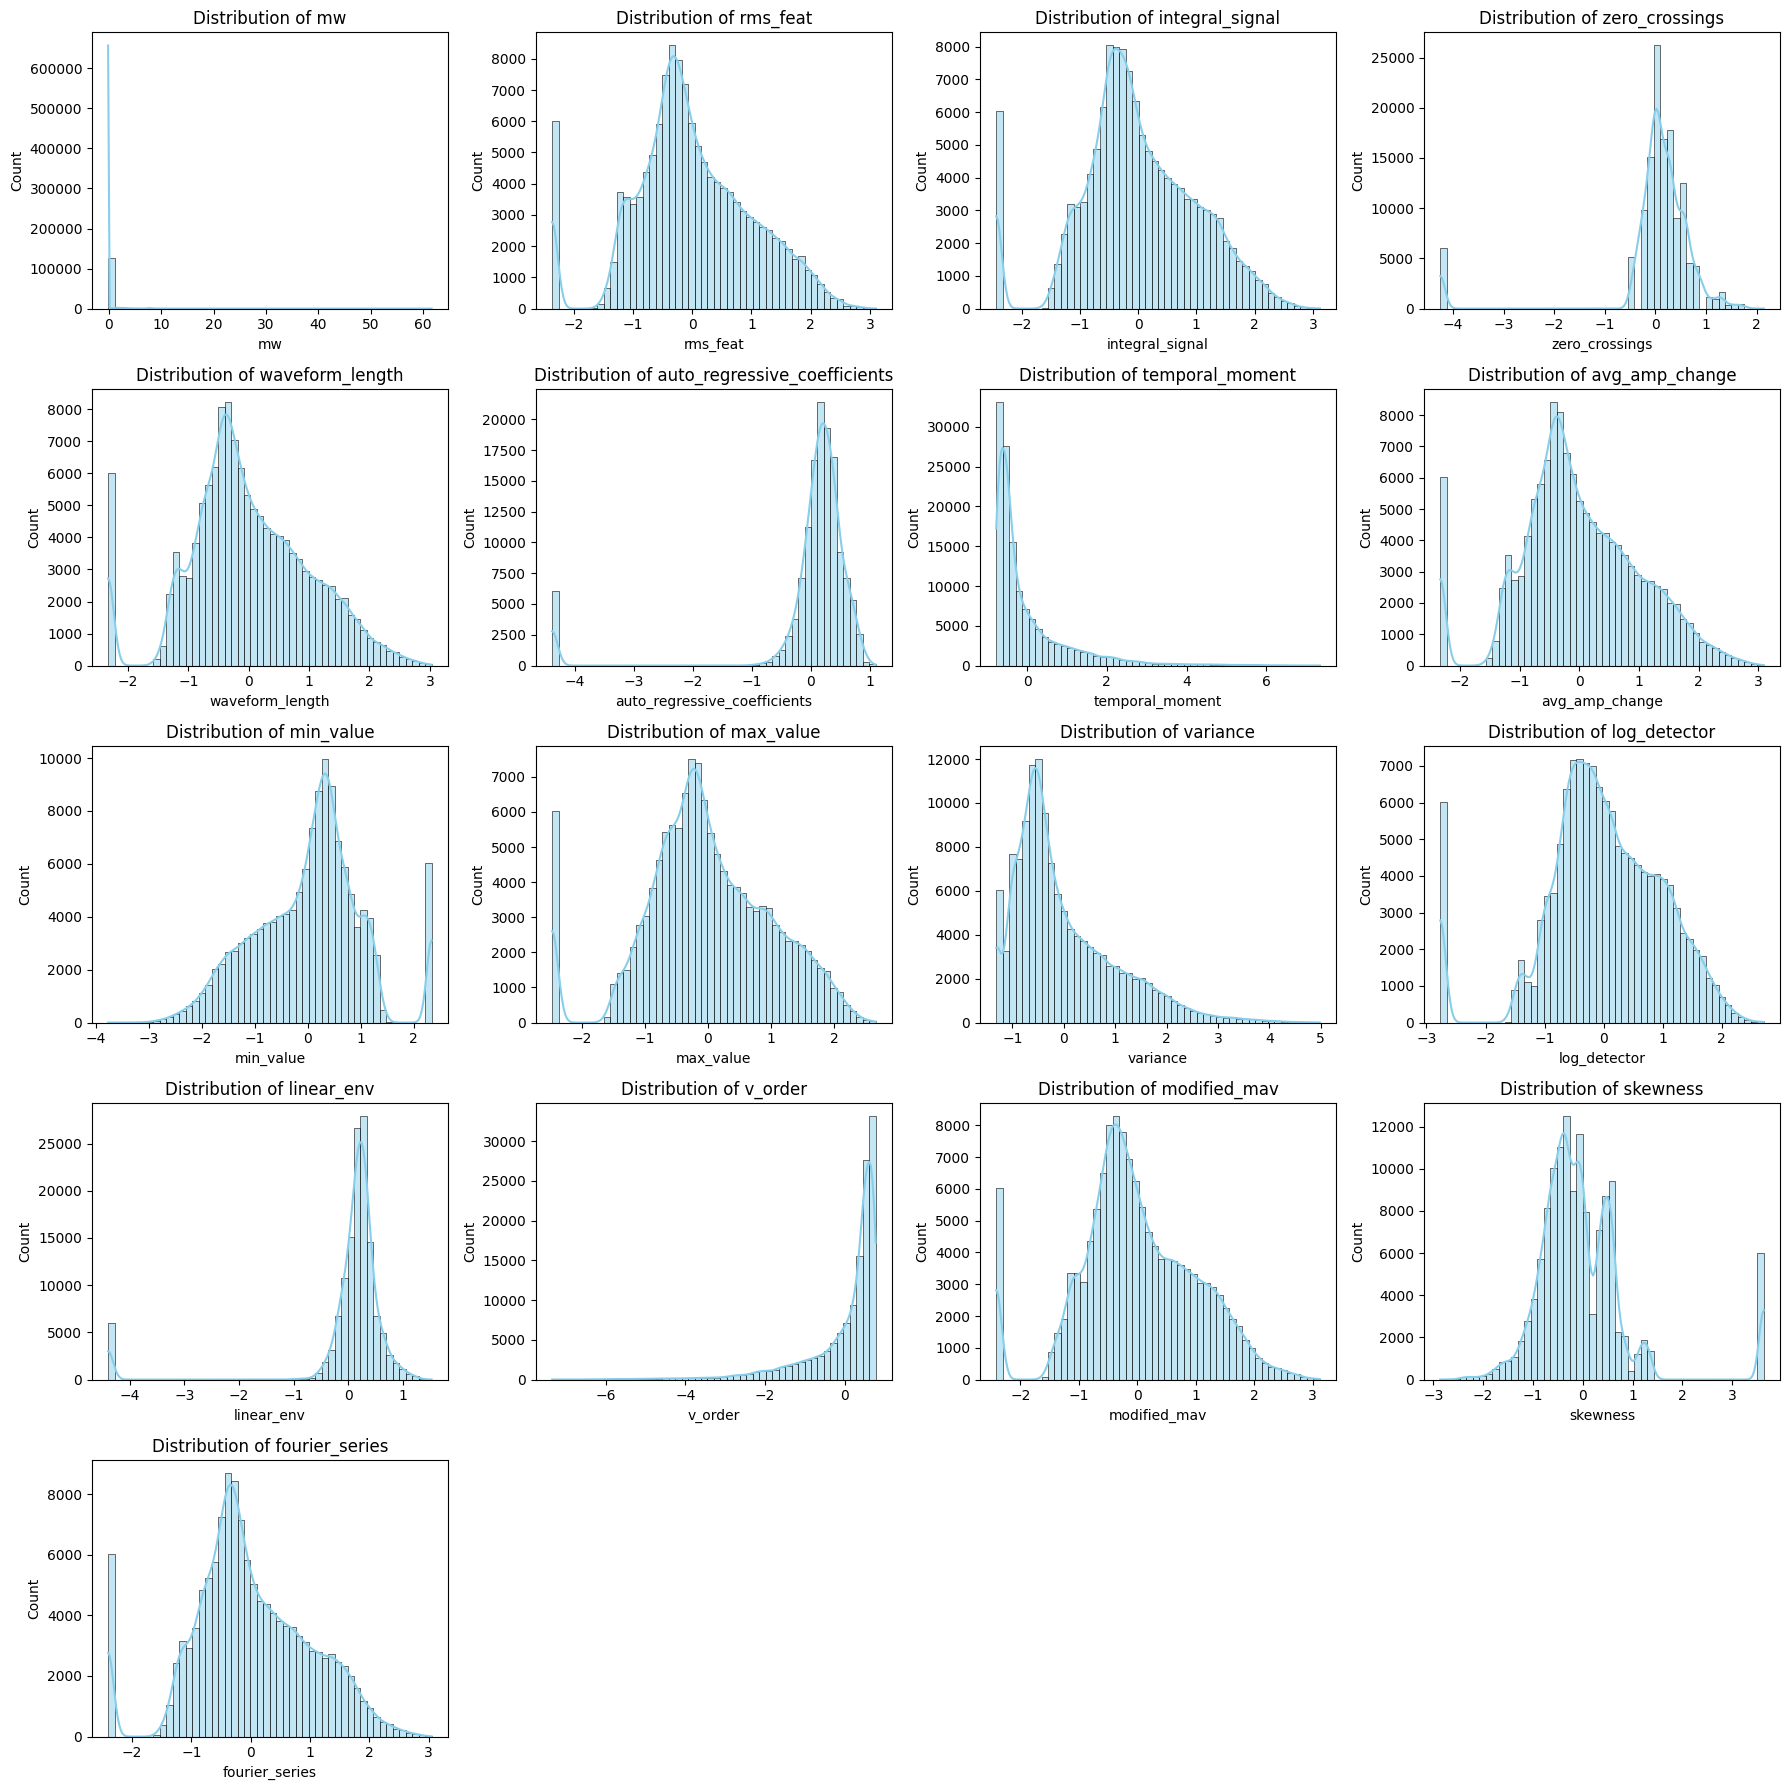

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

<Figure size 640x480 with 0 Axes>

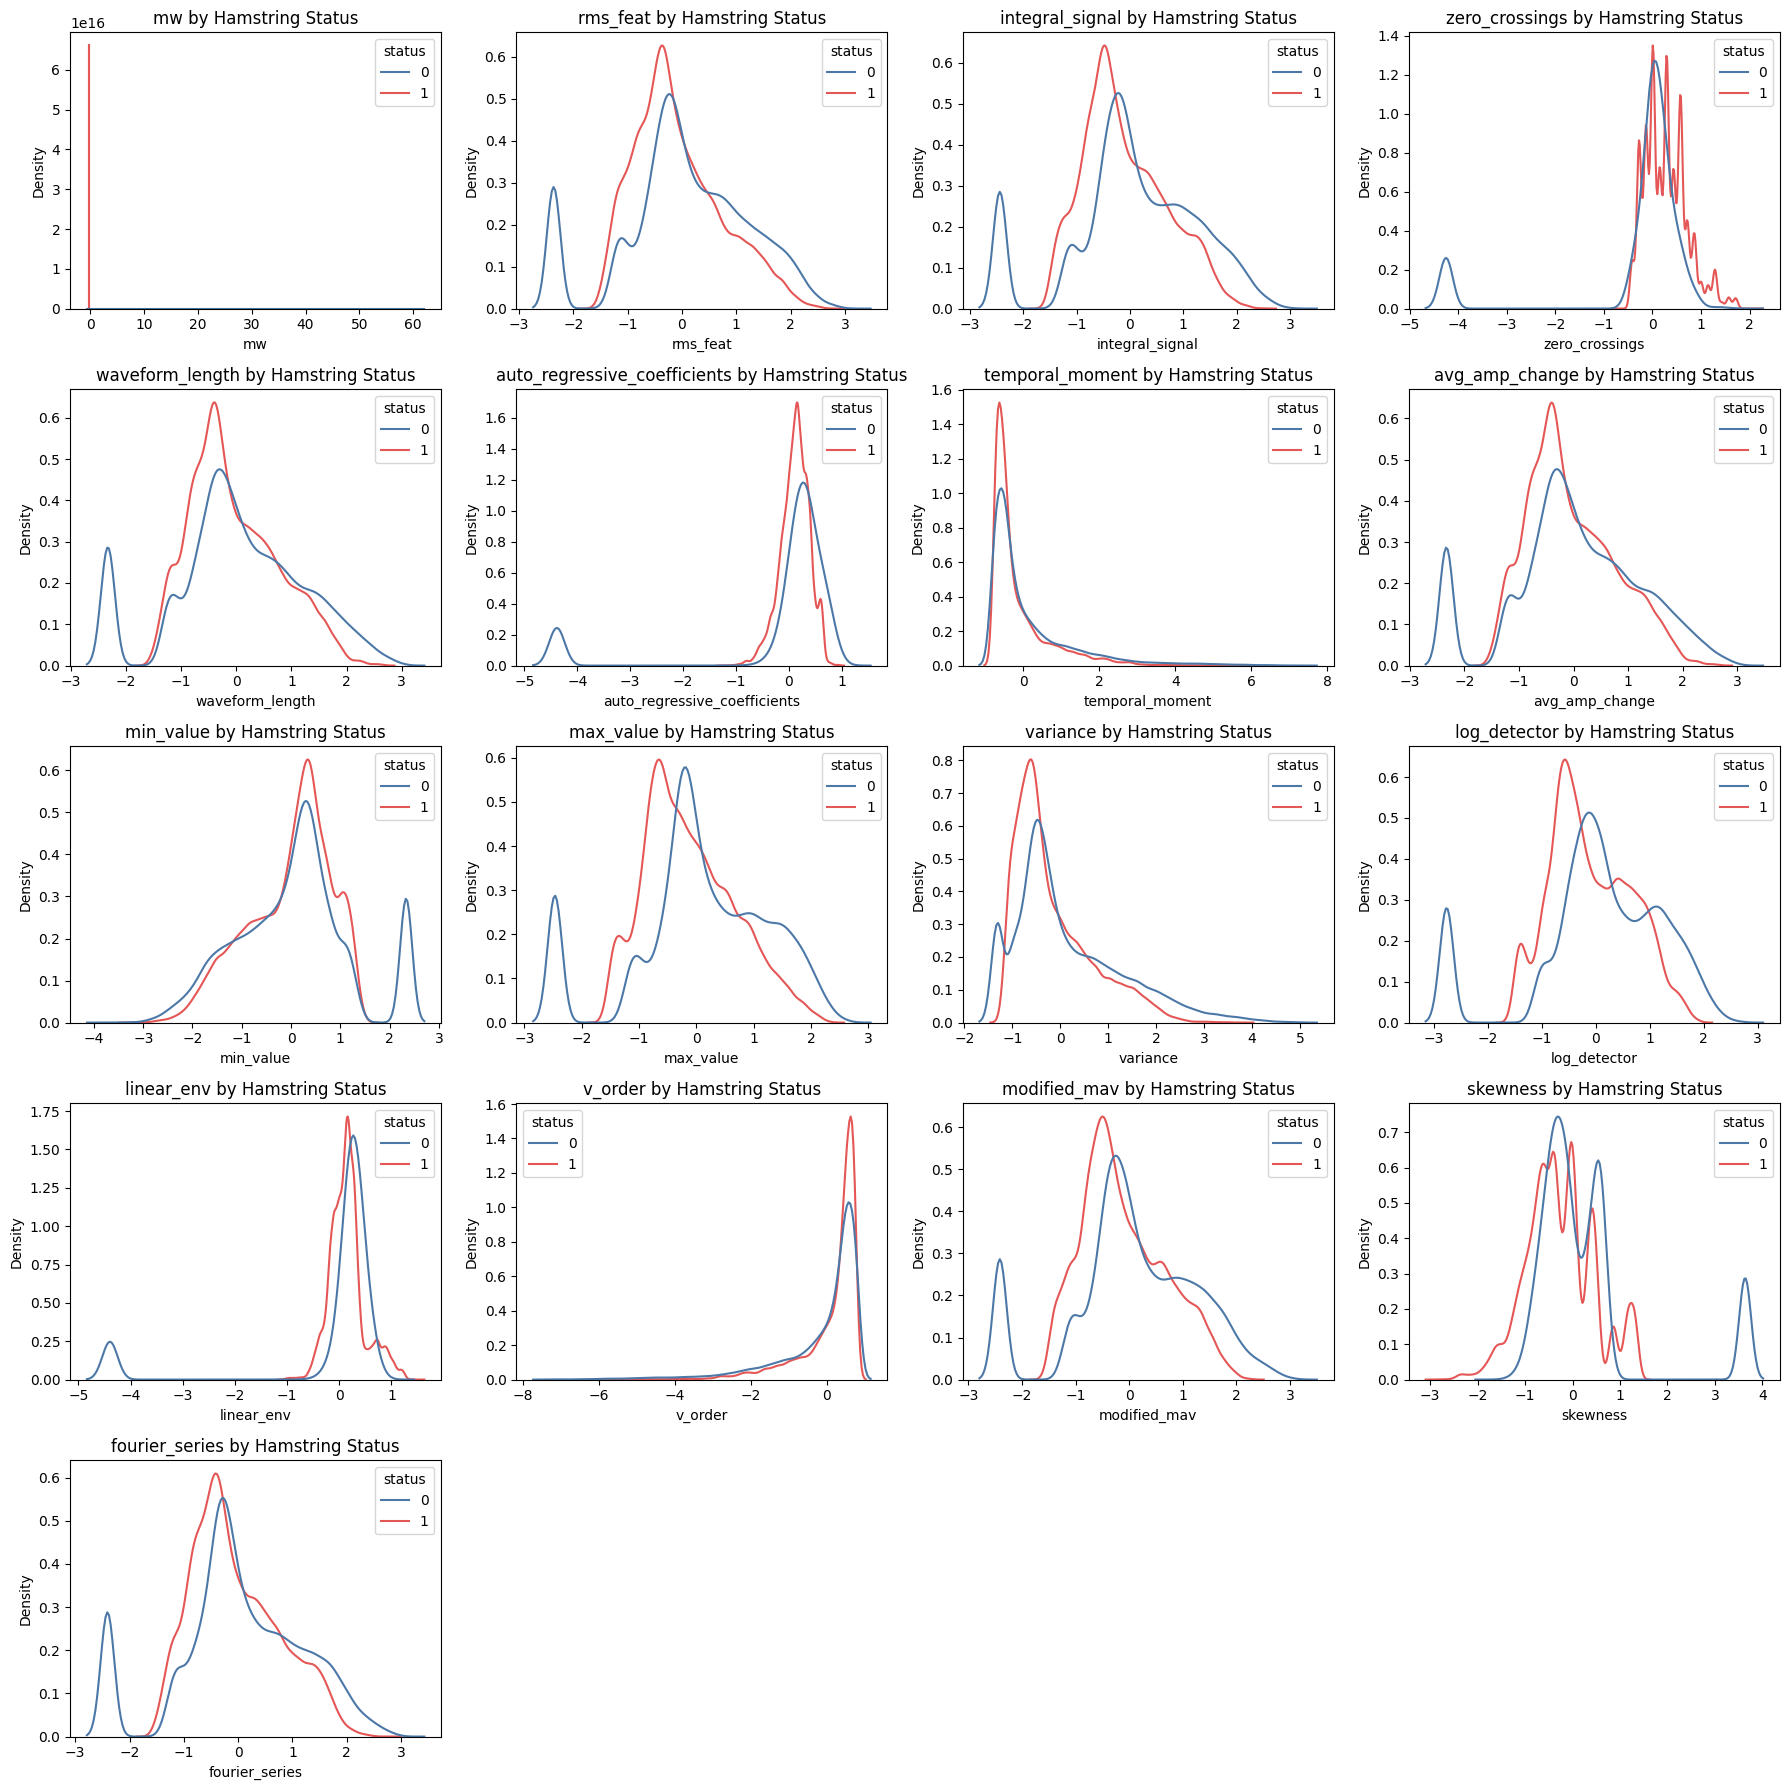

<Figure size 640x480 with 0 Axes>

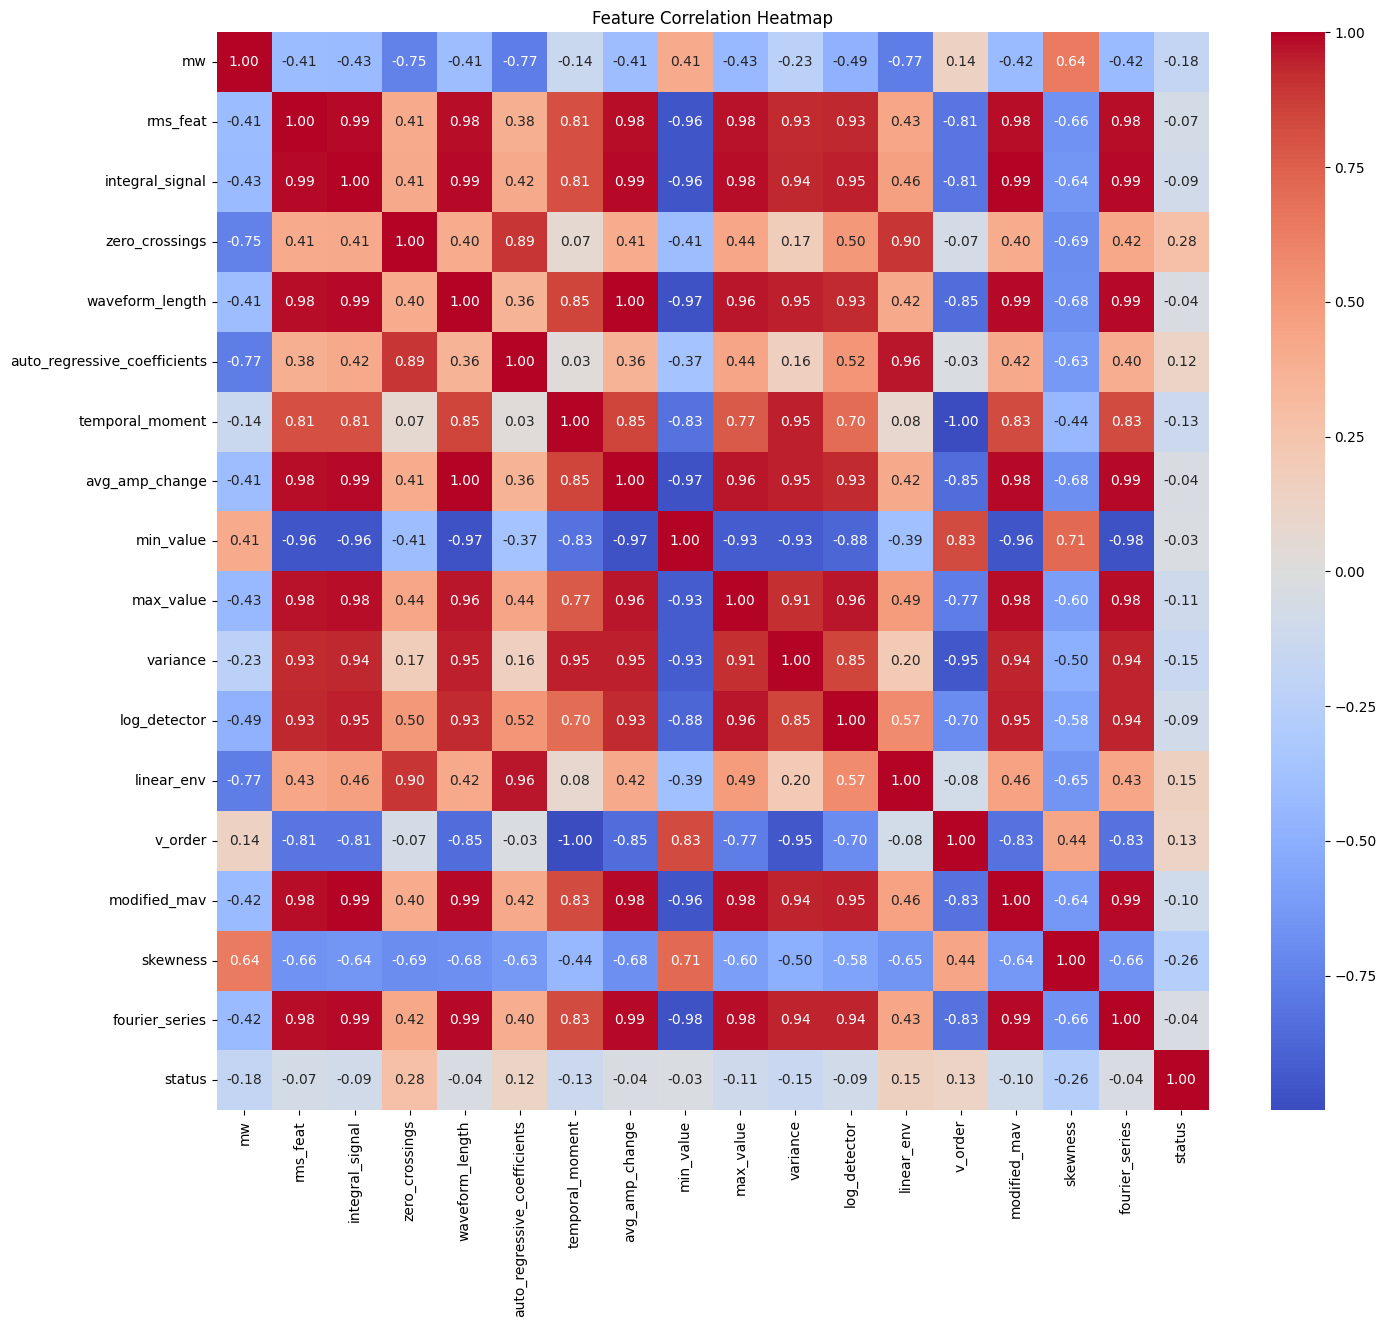

<Figure size 640x480 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numeric columns excluding target
numeric_cols_no_target = [col for col in balanced_model_df.columns if col not in ['status', 'tissue_sweat', 'tissue_urine']]

# 1️⃣ Feature distributions
plt.figure(figsize=(18, 18))
for i, col in enumerate(numeric_cols_no_target):
    plt.subplot(5,4,i+1)
    sns.histplot(balanced_model_df[col], bins=50, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()
plt.savefig('/kaggle/working/graph8.png')

# 2️⃣ Class-wise feature comparison
plt.figure(figsize=(18, 18))
for i, col in enumerate(numeric_cols_no_target):
    plt.subplot(5,4,i+1)
    sns.kdeplot(data=balanced_model_df, x=col, hue='status', common_norm=False, palette=['#4C78A8','#E45756'])
    plt.title(f'{col} by Hamstring Status')
plt.tight_layout()
plt.show()
plt.savefig('/kaggle/working/graph9.png')

# 3️⃣ Correlation heatmap
plt.figure(figsize=(16,14))
corr = balanced_model_df[numeric_cols_no_target + ['status']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()
plt.savefig('/kaggle/working/graph10.png')

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


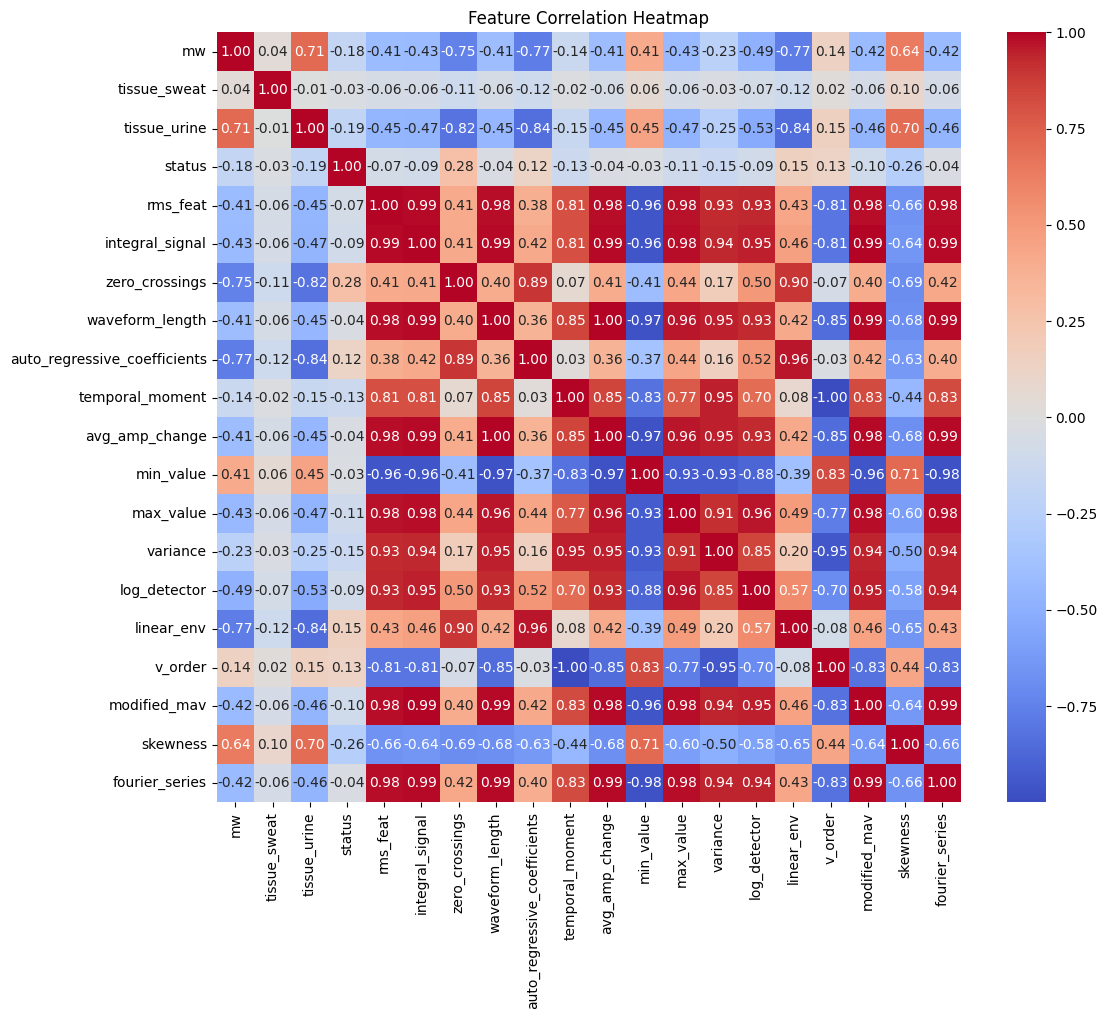

<Figure size 640x480 with 0 Axes>

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = balanced_model_df.corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()
plt.savefig('/kaggle/working/graph11.png')


In [29]:
# Final selected features after removing redundancy
selected_features = [
    'mw', 'tissue_sweat', 'tissue_urine',
    'rms_feat', 'zero_crossings', 'skewness', 'waveform_length'
]

X_final = balanced_model_df[selected_features]
y_final = balanced_model_df['status']

print("Updated feature matrix shape:", X_final.shape)


Updated feature matrix shape: (132044, 7)


In [30]:
from sklearn.model_selection import train_test_split

# First, split into train + temp (train 70%, temp 30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y_final, test_size=0.3, random_state=42, stratify=y_final
)

# Then, split temp into validation and test (each 15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (92430, 7) (92430,)
Validation set shape: (19807, 7) (19807,)
Test set shape: (19807, 7) (19807,)


In [31]:
# Check columns in X_train
print("Current features in X_train:")
print(X_train.columns.tolist())

# Update features to scale based on available columns
features_to_scale = [col for col in X_train.columns if col not in ['status']]  # exclude target

print("Features to scale:")
print(features_to_scale)

# Initialize scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set and transform train, val, test
X_train_scaled = scaler.fit_transform(X_train[features_to_scale])
X_val_scaled = scaler.transform(X_val[features_to_scale])
X_test_scaled = scaler.transform(X_test[features_to_scale])

# Optional: replace in DataFrames
X_train_scaled_df = X_train.copy()
X_train_scaled_df[features_to_scale] = X_train_scaled

X_val_scaled_df = X_val.copy()
X_val_scaled_df[features_to_scale] = X_val_scaled

X_test_scaled_df = X_test.copy()
X_test_scaled_df[features_to_scale] = X_test_scaled

# Quick check
X_train_scaled_df.head()


Current features in X_train:
['mw', 'tissue_sweat', 'tissue_urine', 'rms_feat', 'zero_crossings', 'skewness', 'waveform_length']
Features to scale:
['mw', 'tissue_sweat', 'tissue_urine', 'rms_feat', 'zero_crossings', 'skewness', 'waveform_length']


mw  tissue_sweat  tissue_urine  rms_feat  zero_crossings  \
54603  -0.174432     -0.026731     -0.192085 -0.120800       -0.133031   
117190 -0.174432     -0.026731     -0.192085 -0.302536        0.434247   
38505  -0.174432     -0.026731     -0.192085 -0.567506       -0.133031   
67440  -0.174432     -0.026731     -0.192085  0.104312        0.150608   
61296  -0.174432     -0.026731     -0.192085  1.489988        0.434247   

        skewness  waveform_length  
54603  -0.494580        -0.064497  
117190 -0.633425        -0.428154  
38505   0.595971        -0.779010  
67440  -0.262537         0.092874  
61296  -1.544391         1.864969

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

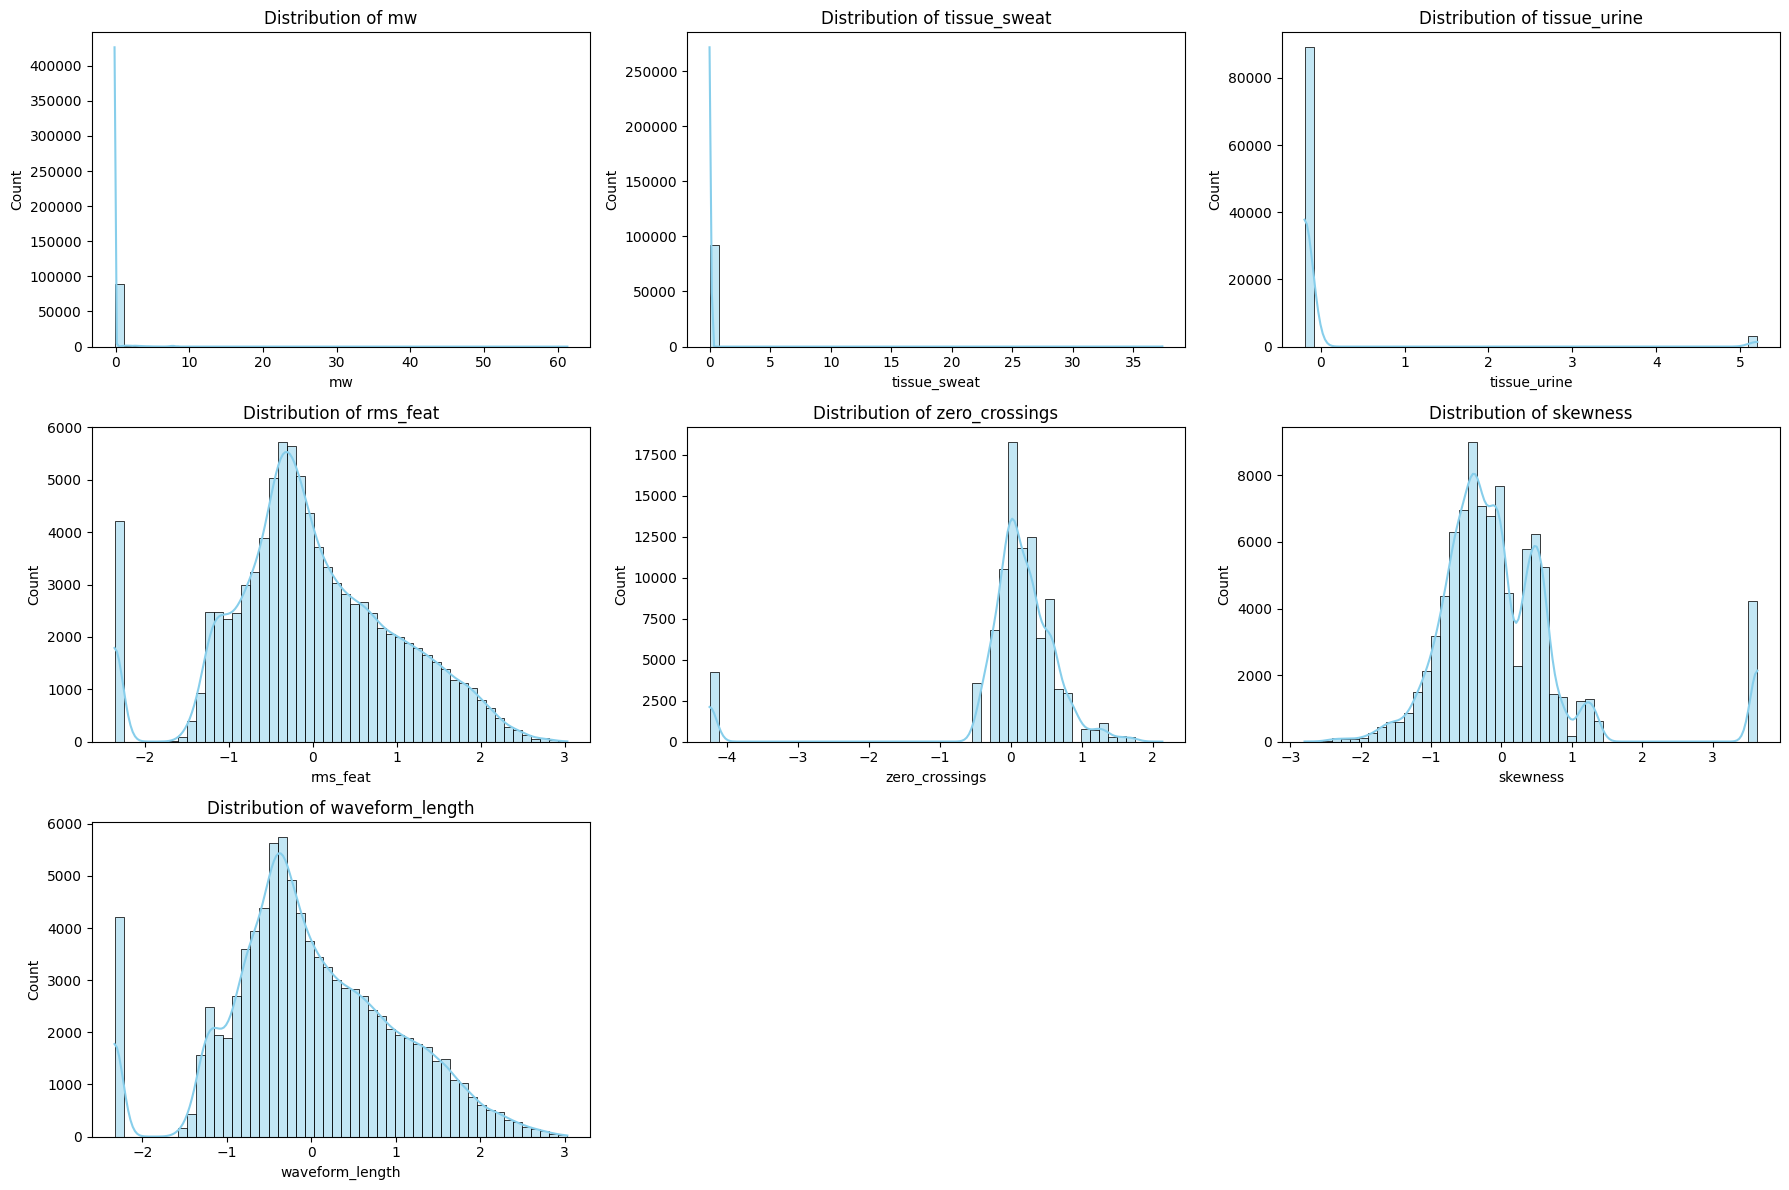

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

scaled_features = ['mw', 'tissue_sweat', 'tissue_urine', 'rms_feat', 
                   'zero_crossings', 'skewness', 'waveform_length']

plt.figure(figsize=(18,12))
for i, col in enumerate(scaled_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(X_train_scaled_df[col], kde=True, bins=50, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()
plt.savefig('/kaggle/working/graph12.png')


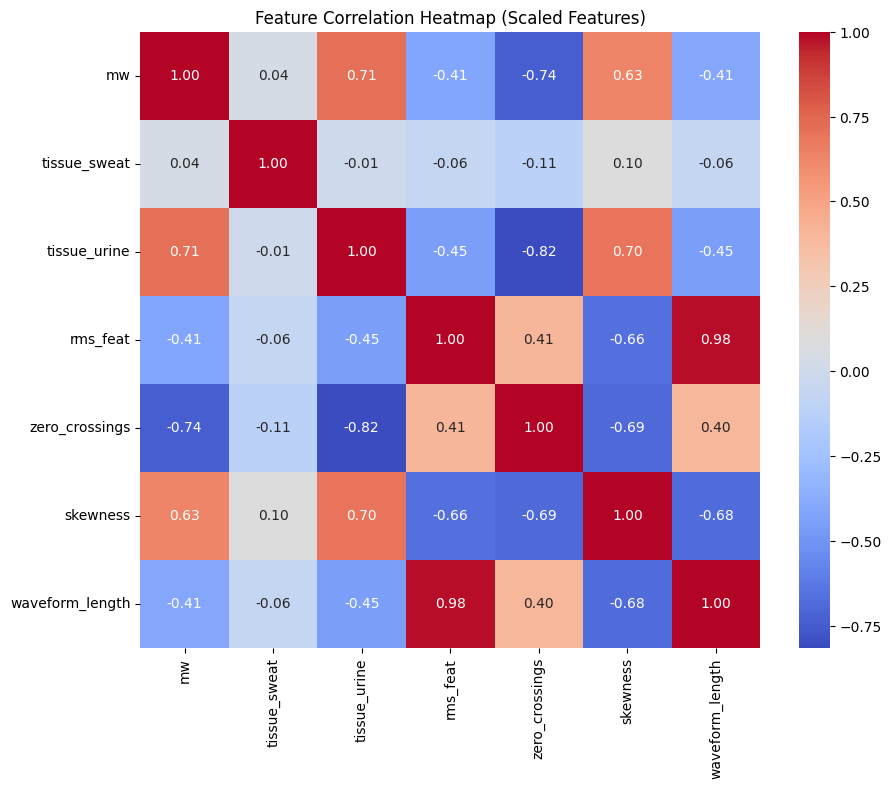

<Figure size 640x480 with 0 Axes>

In [33]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train_scaled_df[scaled_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap (Scaled Features)")
plt.show()
plt.savefig('/kaggle/working/graph13.png')

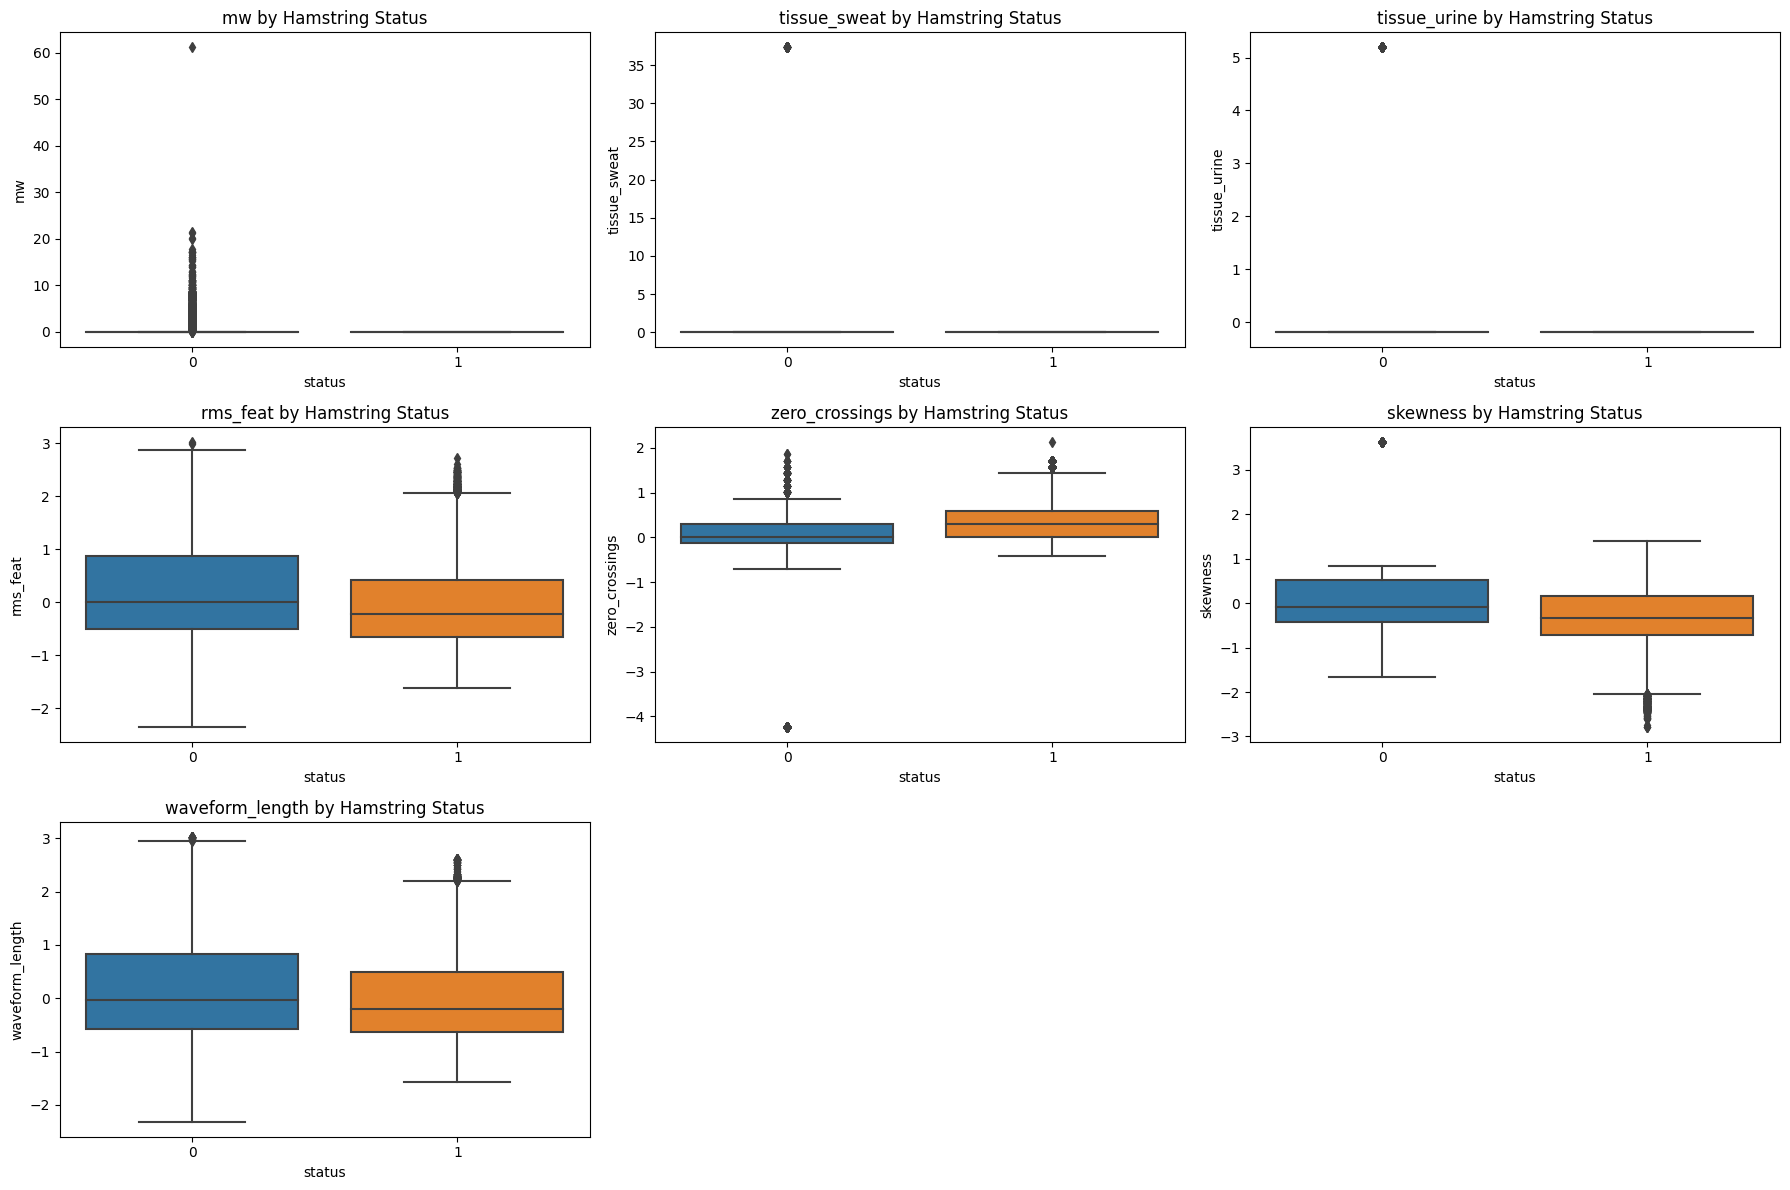

<Figure size 640x480 with 0 Axes>

In [34]:
plt.figure(figsize=(18,12))
for i, col in enumerate(scaled_features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=y_train, y=X_train_scaled_df[col])
    plt.title(f'{col} by Hamstring Status')
plt.tight_layout()
plt.show()
plt.savefig('/kaggle/working/graph14.png')

In [35]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled_df.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled_df.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled_df.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data loaders ready!")


Data loaders ready!


In [36]:
import torch
from torch_geometric.data import Data

# Convert node features to PyTorch tensor
X_nodes = torch.tensor(X_train_scaled, dtype=torch.float)  # shape: [num_nodes, num_features]

# Convert target to tensor
y_nodes = torch.tensor(y_train.values, dtype=torch.long)  # shape: [num_nodes]


In [37]:
from torch_geometric.nn import knn_graph

# Number of neighbors for k-NN graph
k = 5  # you can tune this

# Create edge_index using k-nearest neighbors
# This finds the k nearest nodes for each node based on feature similarity
edge_index = knn_graph(X_nodes, k=k, loop=False)  # shape: [2, num_edges]

# Create PyG Data object
train_data = Data(x=X_nodes, edge_index=edge_index, y=y_nodes)

print(train_data)


Data(x=[92430, 7], edge_index=[2, 462446], y=[92430])


In [38]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

class RGCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations=1):
        super(RGCNModel, self).__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations=num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations=num_relations)
    
    def forward(self, x, edge_index, edge_type=None):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x


In [39]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

# Number of edges
num_edges = edge_index.size(1)

# Since we have a single relation, assign all edges type 0
edge_type = torch.zeros(num_edges, dtype=torch.long).to(device)

# Define R-GCN model
class RGCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(RGCNModel, self).__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations=1)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations=1)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

# Initialize model
model = RGCNModel(in_channels=X_nodes.shape[1], hidden_channels=32, out_channels=2).to(device)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train(model, x, edge_index, edge_type, y, epochs=50):
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        out = model(x, edge_index, edge_type)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        # Accuracy
        _, pred = out.max(dim=1)
        acc = (pred == y).sum().item() / y.size(0)
        
        if epoch % 5 == 0 or epoch == 1:
            print(f'Epoch {epoch:03d}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')

# Train
train(model, X_nodes, edge_index, edge_type, y_nodes, epochs=50)


Epoch 001, Loss: 0.6795, Accuracy: 0.5961
Epoch 005, Loss: 0.5685, Accuracy: 0.7117
Epoch 010, Loss: 0.5389, Accuracy: 0.7167
Epoch 015, Loss: 0.5159, Accuracy: 0.7330
Epoch 020, Loss: 0.4993, Accuracy: 0.7487
Epoch 025, Loss: 0.4839, Accuracy: 0.7504
Epoch 030, Loss: 0.4695, Accuracy: 0.7653
Epoch 035, Loss: 0.4552, Accuracy: 0.7716
Epoch 040, Loss: 0.4428, Accuracy: 0.7836
Epoch 045, Loss: 0.4323, Accuracy: 0.7882
Epoch 050, Loss: 0.4225, Accuracy: 0.7957


In [40]:
# Convert validation and test node features to tensors
X_val_nodes = torch.tensor(X_val_scaled, dtype=torch.float).to(device)
X_test_nodes = torch.tensor(X_test_scaled, dtype=torch.float).to(device)

y_val_nodes = torch.tensor(y_val.values, dtype=torch.long).to(device)
y_test_nodes = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Build k-NN graphs for val and test
from torch_geometric.nn import knn_graph

edge_index_val = knn_graph(X_val_nodes, k=5).to(device)
edge_index_test = knn_graph(X_test_nodes, k=5).to(device)

# Single relation for R-GCN
edge_type_val = torch.zeros(edge_index_val.size(1), dtype=torch.long).to(device)
edge_type_test = torch.zeros(edge_index_test.size(1), dtype=torch.long).to(device)


In [41]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc
import torch.nn.functional as F

def evaluate(model, X, edge_index, edge_type, y):
    model.eval()
    with torch.no_grad():
        out = model(X, edge_index, edge_type)
        _, pred = out.max(dim=1)
        
        y_true = y.cpu().numpy()
        y_pred = pred.cpu().numpy()
        y_prob = F.softmax(out, dim=1)[:,1].cpu().numpy()  # probability for positive class
        
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_prob)
        
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall, precision)
        
    return {"accuracy": acc, "f1_score": f1, "roc_auc": roc_auc, "pr_auc": pr_auc}


In [42]:
val_metrics = evaluate(model, X_val_nodes, edge_index_val, edge_type_val, y_val_nodes)
print("Validation metrics:", val_metrics)

test_metrics = evaluate(model, X_test_nodes, edge_index_test, edge_type_test, y_test_nodes)
print("Test metrics:", test_metrics)


Validation metrics: {'accuracy': 0.7999697076791034, 'f1_score': 0.7877651596314548, 'roc_auc': 0.8838717741005362, 'pr_auc': 0.9023611485633024}
Test metrics: {'accuracy': 0.7994143484626647, 'f1_score': 0.7870732622327027, 'roc_auc': 0.8835149200475632, 'pr_auc': 0.9016242708446763}


In [43]:
# ✅ Save  model
model_path = "/kaggle/working/ RGCN_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/ RGCN_model.pth


RGCN Model Architecture:
GNODEModel(
  (input_proj): Linear(in_features=7, out_features=32, bias=True)
  (odefunc): ODEFunc(
    (gc1): GCNConv(32, 32)
    (gc2): GCNConv(32, 32)
  )
  (linear): Linear(in_features=32, out_features=2, bias=True)
)


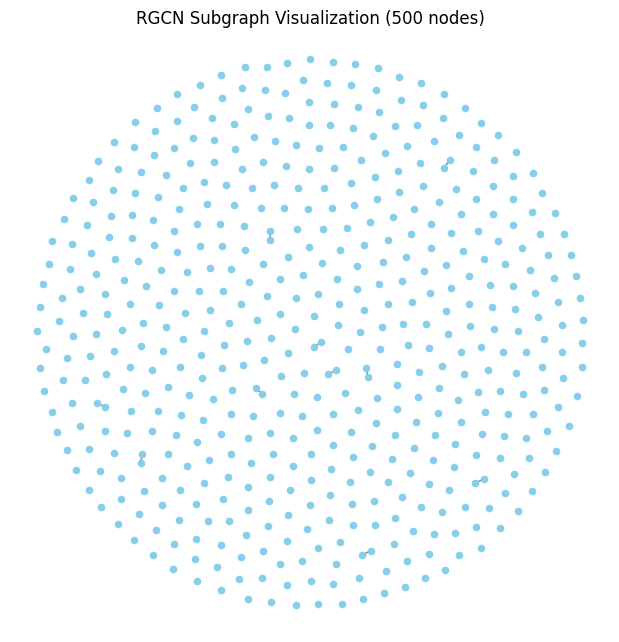

SHAP not supported: GNODEModel.forward() takes 2 positional arguments but 4 were given
LIME not supported: GNODEModel.forward() takes 2 positional arguments but 4 were given
Saliency map not supported: GNODEModel.forward() takes 2 positional arguments but 4 were given


<Figure size 640x480 with 0 Axes>

In [65]:
# --- Imports ---
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, subgraph
import networkx as nx
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer

# --- 1️⃣ Architecture Visualization ---
print("RGCN Model Architecture:")
print(model)

# --- 2️⃣ Graph visualization (subgraph for speed) ---
num_nodes_vis = 500  # visualize first 500 nodes
nodes_vis = torch.arange(num_nodes_vis)
edge_index_vis, _ = subgraph(nodes_vis, edge_index, relabel_nodes=True)
data_vis = Data(x=X_nodes[:num_nodes_vis], edge_index=edge_index_vis)
G_vis = to_networkx(data_vis, to_undirected=True)

plt.figure(figsize=(6,6))
nx.draw(G_vis, node_size=20, node_color='skyblue', edge_color='gray')
plt.title("RGCN Subgraph Visualization (500 nodes)")
plt.show()
plt.savefig('/kaggle/working/rgcnexp1.png')

# --- 3️⃣ SHAP Feature Importance ---
try:
    model.eval()
    # Use only nodes in the subgraph for SHAP
    X_sample = X_nodes[:num_nodes_vis].cpu().numpy()
    edge_index_sample = edge_index_vis
    edge_type_sample = edge_type[:edge_index_sample.size(1)]
    
    explainer = shap.Explainer(
        lambda x: F.softmax(model(torch.tensor(x, dtype=torch.float, device=device),
                                   edge_index_sample,
                                   edge_type_sample).detach().cpu().numpy(), axis=1),
        X_sample
    )
    shap_values = explainer(X_sample)
    shap.summary_plot(shap_values, X_sample, feature_names=[f"feat{i}" for i in range(X_sample.shape[1])])
except Exception as e:
    print(f"SHAP not supported: {e}")

# --- 4️⃣ LIME for local explainability ---
try:
    explainer = LimeTabularExplainer(
        X_sample,
        feature_names=[f"feat{i}" for i in range(X_sample.shape[1])],
        class_names=['No Injury', 'Injury'],
        discretize_continuous=True
    )
    i = 0  # explain first node
    exp = explainer.explain_instance(
        X_sample[i],
        lambda x: F.softmax(model(torch.tensor(x, dtype=torch.float, device=device),
                                   edge_index_sample,
                                   edge_type_sample).detach().cpu().numpy(), axis=1)
    )
    exp.show_in_notebook(show_table=True)
except Exception as e:
    print(f"LIME not supported: {e}")

# --- 5️⃣ Saliency Map / Grad-based feature importance ---
try:
    X_tensor = X_nodes[:num_nodes_vis].clone().detach().requires_grad_(True)
    output = model(X_tensor, edge_index_vis, edge_type[:edge_index_vis.size(1)])
    target = output[:,1].sum()  # focus on injury class
    target.backward()
    saliency = X_tensor.grad.abs().max(dim=1)[0].cpu().numpy()
    
    plt.figure(figsize=(6,3))
    plt.bar(range(len(saliency)), saliency)
    plt.title("RGCN Saliency Map (max feature gradients per node)")
    plt.show()
    plt.savefig('/kaggle/working/rgcnexp2.png')
except Exception as e:
    print(f"Saliency map not supported: {e}")


In [66]:
# Check for time-related columns
time_cols = [col for col in combined_model_df.columns if 'time' in col.lower() or 'session' in col.lower()]
print("Potential temporal columns:", time_cols)

# If we have player_id or biomarker_id, check number of timesteps per entity
if 'player_id' in combined_model_df.columns:
    player_counts = combined_model_df.groupby('player_id').size()
    print("Number of timepoints per player (sample):")
    print(player_counts.head(10))
    print(f"Min timesteps: {player_counts.min()}, Max timesteps: {player_counts.max()}")
else:
    print("No 'player_id' column found. Temporal sequences may not exist.")

# Optional: visualize distribution of timesteps per player
import matplotlib.pyplot as plt

if 'player_id' in combined_model_df.columns:
    plt.hist(player_counts, bins=20)
    plt.xlabel('Number of timesteps per player')
    plt.ylabel('Count of players')
    plt.title('Temporal sequence distribution per player')
    plt.show()


Potential temporal columns: []
No 'player_id' column found. Temporal sequences may not exist.


In [67]:
# Import NumPy
import numpy as np
import torch

# Combine all splits into a full node feature tensor
X_nodes_full = torch.tensor(
    np.vstack([X_train_scaled, X_val_scaled, X_test_scaled]),
    dtype=torch.float
)

# Combine labels
y_nodes_full = torch.tensor(
    np.hstack([y_train.values, y_val.values, y_test.values]),
    dtype=torch.long
)

# Create masks for train, validation, and test
num_nodes = X_nodes_full.shape[0]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)

# Assign True for the correct indices
train_mask[:X_train_scaled.shape[0]] = True
val_mask[X_train_scaled.shape[0]:X_train_scaled.shape[0]+X_val_scaled.shape[0]] = True
test_mask[X_train_scaled.shape[0]+X_val_scaled.shape[0]:] = True

# Verify counts
print("Train nodes:", train_mask.sum().item())
print("Validation nodes:", val_mask.sum().item())
print("Test nodes:", test_mask.sum().item())


Train nodes: 92430
Validation nodes: 19807
Test nodes: 19807


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv  # Or appropriate graph layer for GLN

# Define a simple GLN-like model
class GLNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GLNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model
model = GLNModel(in_channels=X_nodes_full.shape[1], hidden_channels=32, out_channels=2).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train_gln(model, x, edge_index, y, train_mask, epochs=50):
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        out = model(x, edge_index)
        loss = criterion(out[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()

        _, pred = out[train_mask].max(dim=1)
        acc = (pred == y[train_mask]).sum().item() / train_mask.sum().item()
        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

# Train
train_gln(model, X_nodes_full, edge_index, y_nodes_full, train_mask, epochs=50)


Epoch 001, Loss: 0.9017, Accuracy: 0.5096
Epoch 005, Loss: 0.6760, Accuracy: 0.5507
Epoch 010, Loss: 0.6147, Accuracy: 0.6559
Epoch 015, Loss: 0.5829, Accuracy: 0.6962
Epoch 020, Loss: 0.5657, Accuracy: 0.7001
Epoch 025, Loss: 0.5501, Accuracy: 0.7121
Epoch 030, Loss: 0.5377, Accuracy: 0.7202
Epoch 035, Loss: 0.5249, Accuracy: 0.7275
Epoch 040, Loss: 0.5132, Accuracy: 0.7363
Epoch 045, Loss: 0.5018, Accuracy: 0.7423
Epoch 050, Loss: 0.4914, Accuracy: 0.7508


In [69]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

def evaluate_gln(model, x, edge_index, y, mask):
    """
    Evaluate GLN model on given mask.
    Returns: dictionary of metrics
    """
    model.eval()
    with torch.no_grad():
        out = model(x, edge_index)
        # Predicted class
        _, preds = out[mask].max(dim=1)
        # Predicted probabilities for ROC-AUC and PR-AUC
        probs = F.softmax(out[mask], dim=1)[:, 1].cpu().numpy()
        y_true = y[mask].cpu().numpy()
        
        metrics = {
            'accuracy': accuracy_score(y_true, preds.cpu().numpy()),
            'f1_score': f1_score(y_true, preds.cpu().numpy()),
            'roc_auc': roc_auc_score(y_true, probs),
            'pr_auc': average_precision_score(y_true, probs)
        }
    return metrics

# Evaluate
val_metrics = evaluate_gln(model, X_nodes_full, edge_index, y_nodes_full, val_mask)
test_metrics = evaluate_gln(model, X_nodes_full, edge_index, y_nodes_full, test_mask)

print("Validation metrics:", val_metrics)
print("Test metrics:", test_metrics)


Validation metrics: {'accuracy': 0.7555914575655072, 'f1_score': 0.7441196680585656, 'roc_auc': 0.8379139068593793, 'pr_auc': 0.8582140939475237}
Test metrics: {'accuracy': 0.7547836623415964, 'f1_score': 0.7420468426363587, 'roc_auc': 0.8379200702386657, 'pr_auc': 0.8569576645669281}


In [70]:
# ✅ Save  model
model_path = "/kaggle/working/ GLN_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/ GLN_model.pth


GLN Model Architecture:
GLNModel(
  (conv1): GCNConv(7, 32)
  (conv2): GCNConv(32, 2)
)


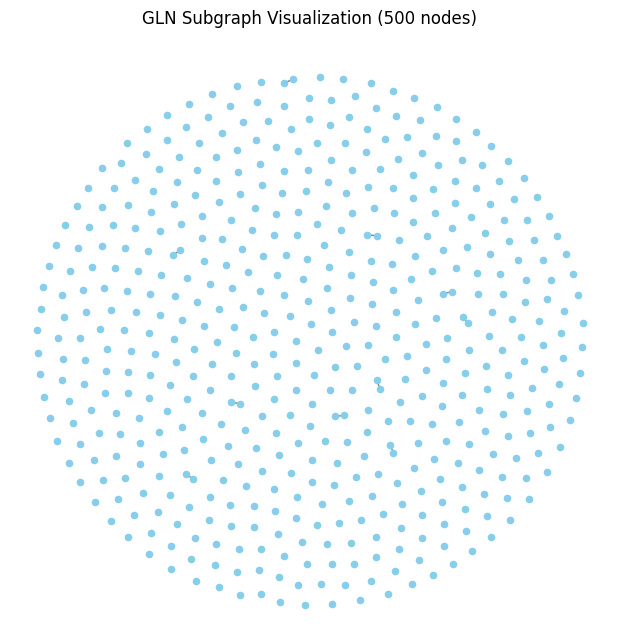

SHAP not supported for GLN: only integer scalar arrays can be converted to a scalar index


<Figure size 640x480 with 0 Axes>

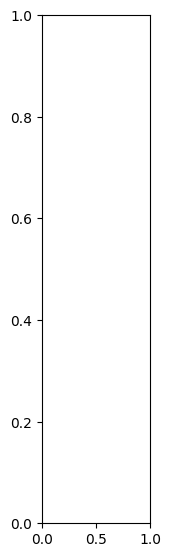

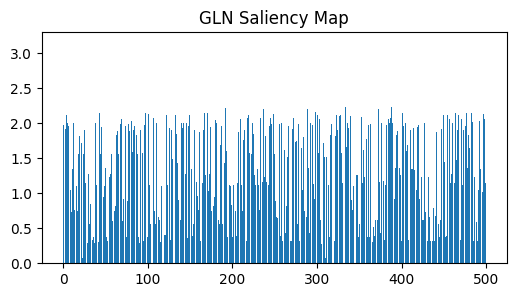

<Figure size 640x480 with 0 Axes>

In [71]:
# --- Imports ---
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, subgraph
import networkx as nx
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer

# Ensure 'model' points to your GLN model
print("GLN Model Architecture:")
print(model)

# --- 1️⃣ Subgraph visualization ---
num_nodes_vis = 500
nodes_vis = torch.arange(num_nodes_vis)
edge_index_vis, _ = subgraph(nodes_vis, edge_index, relabel_nodes=True)
data_vis = Data(x=X_nodes_full[:num_nodes_vis], edge_index=edge_index_vis)
G_vis = to_networkx(data_vis, to_undirected=True)

plt.figure(figsize=(6,6))
nx.draw(G_vis, node_size=20, node_color='skyblue', edge_color='gray')
plt.title("GLN Subgraph Visualization (500 nodes)")
plt.show()
plt.savefig('/kaggle/working/gln_subgraph.png')

# --- 2️⃣ SHAP Feature Importance ---
try:
    model.eval()
    X_sample = X_nodes_full[:num_nodes_vis].cpu().numpy()
    explainer = shap.Explainer(
        lambda x: F.softmax(model(torch.tensor(x, dtype=torch.float, device=device),
                                  edge_index_vis), dim=1).detach().cpu().numpy(),
        X_sample
    )
    shap_values = explainer(X_sample)
    shap.summary_plot(shap_values, X_sample, feature_names=[f"feat{i}" for i in range(X_sample.shape[1])])
except Exception as e:
    print(f"SHAP not supported for GLN: {e}")

# --- 3️⃣ LIME Explainability ---
try:
    explainer = LimeTabularExplainer(
        X_sample,
        feature_names=[f"feat{i}" for i in range(X_sample.shape[1])],
        class_names=['No Injury', 'Injury'],
        discretize_continuous=True
    )
    i = 0
    exp = explainer.explain_instance(
        X_sample[i],
        lambda x: F.softmax(model(torch.tensor(x, dtype=torch.float, device=device),
                                  edge_index_vis), dim=1).detach().cpu().numpy()
    )
    exp.show_in_notebook(show_table=True)
except Exception as e:
    print(f"LIME not supported for GLN: {e}")

# --- 4️⃣ Saliency Map ---
try:
    X_tensor = X_nodes_full[:num_nodes_vis].clone().detach().requires_grad_(True)
    output = model(X_tensor, edge_index_vis)
    target = output[:,1].sum()
    target.backward()
    saliency = X_tensor.grad.abs().max(dim=1)[0].cpu().numpy()

    plt.figure(figsize=(6,3))
    plt.bar(range(len(saliency)), saliency)
    plt.title("GLN Saliency Map")
    plt.show()
    plt.savefig('/kaggle/working/gln_saliency.png')
except Exception as e:
    print(f"Saliency map not supported for GLN: {e}")

# --- 5️⃣ Attention weights (if applicable) ---
if hasattr(model, "attention_weights"):
    try:
        att_weights = model.attention_weights
        plt.figure(figsize=(6,4))
        plt.imshow(att_weights.detach().cpu().numpy(), cmap='viridis')
        plt.colorbar()
        plt.title("GLN Attention Heatmap")
        plt.show()
    except Exception as e:
        print(f"Attention visualization not available for GLN: {e}")


In [51]:
!pip install torchdiffeq


In [72]:
# 1️⃣ Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torchdiffeq import odeint  # ODE solver for continuous dynamics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cpu


In [73]:
# ODE function with edge_index included
class ODEFunc(nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_index):
        super(ODEFunc, self).__init__()
        self.edge_index = edge_index
        self.gc1 = GCNConv(in_channels, hidden_channels)
        self.gc2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, t, x):
        # t is required by torchdiffeq, even if unused
        x = self.gc1(x, self.edge_index)
        x = F.relu(x)
        x = self.gc2(x, self.edge_index)
        return x

# GNODE model
class GNODEModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_index):
        super(GNODEModel, self).__init__()
        self.odefunc = ODEFunc(in_channels, hidden_channels, edge_index)
        self.linear = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        # Solve ODE from t0=0 to t1=1
        t = torch.tensor([0, 1], dtype=torch.float)
        out = odeint(self.odefunc, x, t, method='rk4', options={'step_size':0.1})
        out = out[-1]  # take last time step
        out = self.linear(out)
        return out


In [74]:
# Fixed GNODE model
class GNODEModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_index):
        super(GNODEModel, self).__init__()
        self.input_proj = nn.Linear(in_channels, hidden_channels)  # Project input features
        self.odefunc = ODEFunc(hidden_channels, hidden_channels, edge_index)  # Hidden dim in ODE
        self.linear = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        # Project input to hidden dimension
        x = self.input_proj(x)
        x = F.relu(x)
        
        # Solve ODE from t0=0 to t1=1
        t = torch.tensor([0, 1], dtype=torch.float)
        out = odeint(self.odefunc, x, t, method='rk4', options={'step_size':0.1})
        out = out[-1]  # take last time step
        out = self.linear(out)
        return out


In [75]:
# Initialize GNODE model
model = GNODEModel(
    in_channels=X_nodes.shape[1],
    hidden_channels=32,
    out_channels=2,
    edge_index=edge_index
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train_gnode(model, x, y, epochs=50):
    model.train()
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        out = model(x)  # forward pass
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        # Accuracy
        _, pred = out.max(dim=1)
        acc = (pred == y).sum().item() / y.size(0)
        
        if epoch % 5 == 0 or epoch == 1:
            print(f'Epoch {epoch:03d}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')

# Train the model
train_gnode(model, X_nodes, y_nodes, epochs=50)


Epoch 001, Loss: 0.7395, Accuracy: 0.4613
Epoch 005, Loss: 0.6198, Accuracy: 0.6181
Epoch 010, Loss: 0.5718, Accuracy: 0.6986
Epoch 015, Loss: 0.5064, Accuracy: 0.7396
Epoch 020, Loss: 0.4327, Accuracy: 0.7885
Epoch 025, Loss: 0.4154, Accuracy: 0.7895
Epoch 030, Loss: 0.3862, Accuracy: 0.8046
Epoch 035, Loss: 0.3747, Accuracy: 0.8138
Epoch 040, Loss: 0.3706, Accuracy: 0.8136
Epoch 045, Loss: 0.3613, Accuracy: 0.8175
Epoch 050, Loss: 0.3564, Accuracy: 0.8202


In [76]:
# Combine all nodes into a single tensor
X_all_nodes = X_nodes.to(device)  # training nodes
y_all_nodes = y_nodes.to(device)

# Since you have no validation nodes, mask for test nodes
test_mask = torch.zeros(X_all_nodes.size(0), dtype=torch.bool)
test_mask[-19807:] = True  # last 19807 nodes are test

# Evaluate using the mask
def evaluate_gnode_full(model, X, y, mask):
    model.eval()
    with torch.no_grad():
        out = model(X)
        probs = F.softmax(out, dim=1)[:,1].cpu().numpy()
        preds = out.max(dim=1)[1].cpu().numpy()
        y_true = y.cpu().numpy()
        
        metrics = {
            'accuracy': accuracy_score(y_true[mask], preds[mask]),
            'f1_score': f1_score(y_true[mask], preds[mask]),
            'roc_auc': roc_auc_score(y_true[mask], probs[mask]),
            'pr_auc': average_precision_score(y_true[mask], probs[mask])
        }
    return metrics

test_metrics = evaluate_gnode_full(model, X_all_nodes, y_all_nodes, test_mask)
print("Test metrics:", test_metrics)


Test metrics: {'accuracy': 0.8199626394708941, 'f1_score': 0.7982346950322508, 'roc_auc': 0.9044469029999919, 'pr_auc': 0.9210603593835053}


In [77]:
# ✅ Save GNODE model
model_path = "/kaggle/working/gnode_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")


Model saved at: /kaggle/working/gnode_model.pth


GNODE Model Architecture:
GNODEModel(
  (input_proj): Linear(in_features=7, out_features=32, bias=True)
  (odefunc): ODEFunc(
    (gc1): GCNConv(32, 32)
    (gc2): GCNConv(32, 32)
  )
  (linear): Linear(in_features=32, out_features=2, bias=True)
)


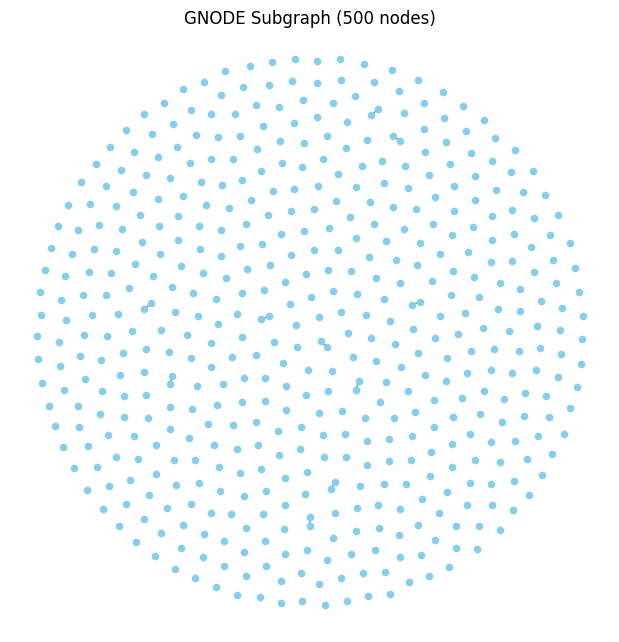

SHAP not supported for GNODE: index 5984 is out of bounds for dimension 0 with size 5984
LIME not supported for GNODE: index 5000 is out of bounds for dimension 0 with size 5000
Saliency map not supported for GNODE: index 500 is out of bounds for dimension 0 with size 500


<Figure size 640x480 with 0 Axes>

In [78]:
# --- Imports ---
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, subgraph
import networkx as nx
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer

# --- 1️⃣ Print Architecture ---
print("GNODE Model Architecture:")
print(model)

# --- 2️⃣ Subgraph Visualization ---
num_nodes_vis = min(500, X_all_nodes.size(0))  # max safe nodes
nodes_vis = torch.arange(num_nodes_vis)

# Subgraph edges (relabel nodes to 0..num_nodes_vis-1)
edge_index_vis, _ = subgraph(nodes_vis, edge_index, relabel_nodes=True)

# Subgraph features
X_sample = X_all_nodes[nodes_vis].clone().detach().cpu().numpy()

# Data object for NetworkX
data_vis = Data(x=X_all_nodes[nodes_vis], edge_index=edge_index_vis)
G_vis = to_networkx(data_vis, to_undirected=True)

plt.figure(figsize=(6,6))
nx.draw(G_vis, node_size=20, node_color='skyblue', edge_color='gray')
plt.title(f"GNODE Subgraph ({num_nodes_vis} nodes)")
plt.show()
plt.savefig('/kaggle/working/gnode_subgraph.png')

# --- 3️⃣ SHAP Feature Importance ---
try:
    model.eval()
    explainer = shap.Explainer(
        lambda x: F.softmax(model(torch.tensor(x, dtype=torch.float, device=device)), dim=1).detach().cpu().numpy(),
        X_sample
    )
    shap_values = explainer(X_sample)
    shap.summary_plot(shap_values, X_sample, feature_names=[f"feat{i}" for i in range(X_sample.shape[1])])
except Exception as e:
    print(f"SHAP not supported for GNODE: {e}")

# --- 4️⃣ LIME Local Explainability ---
try:
    explainer = LimeTabularExplainer(
        X_sample,
        feature_names=[f"feat{i}" for i in range(X_sample.shape[1])],
        class_names=['No Injury', 'Injury'],
        discretize_continuous=True
    )
    i = 0  # explain first node
    exp = explainer.explain_instance(
        X_sample[i],
        lambda x: F.softmax(model(torch.tensor(x, dtype=torch.float, device=device)), dim=1).detach().cpu().numpy()
    )
    exp.show_in_notebook(show_table=True)
except Exception as e:
    print(f"LIME not supported for GNODE: {e}")

# --- 5️⃣ Saliency Map ---
try:
    X_tensor = torch.tensor(X_sample, dtype=torch.float, device=device, requires_grad=True)
    output = model(X_tensor)
    target = output[:,1].sum()  # focus on injury class
    target.backward()
    saliency = X_tensor.grad.abs().max(dim=1).cpu().numpy()

    plt.figure(figsize=(6,3))
    plt.bar(range(len(saliency)), saliency)
    plt.title(f"GNODE Saliency Map ({num_nodes_vis} nodes)")
    plt.show()
    plt.savefig('/kaggle/working/gnode_saliency.png')
except Exception as e:
    print(f"Saliency map not supported for GNODE: {e}")


In [79]:
# Check if main variables exist and print their shapes
variables = [
    "X_train_nodes", "y_train_nodes",
    "X_val_nodes", "y_val_nodes",
    "X_test_nodes", "y_test_nodes",
    "edge_index", "device"
]

for var in variables:
    if var in globals():
        value = eval(var)
        try:
            print(f"{var}: {value.shape}")
        except AttributeError:
            print(f"{var}: {type(value)}")
    else:
        print(f"{var} ❌ NOT FOUND")


X_train_nodes ❌ NOT FOUND
y_train_nodes ❌ NOT FOUND
X_val_nodes: torch.Size([19807, 7])
y_val_nodes: torch.Size([19807])
X_test_nodes: torch.Size([19807, 7])
y_test_nodes: torch.Size([19807])
edge_index: torch.Size([2, 462446])
device: <class 'torch.device'>


In [80]:
from sklearn.model_selection import train_test_split

# Assuming X_nodes and y_nodes still exist
# If not, we’ll reload them next
if "X_nodes" in globals() and "y_nodes" in globals():
    X_train_nodes, X_temp, y_train_nodes, y_temp = train_test_split(
        X_nodes, y_nodes, test_size=0.4, random_state=42, stratify=y_nodes
    )

    X_val_nodes, X_test_nodes, y_val_nodes, y_test_nodes = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"Train: {X_train_nodes.shape}, {y_train_nodes.shape}")
    print(f"Val: {X_val_nodes.shape}, {y_val_nodes.shape}")
    print(f"Test: {X_test_nodes.shape}, {y_test_nodes.shape}")
else:
    print("X_nodes or y_nodes not found — we’ll reload the dataset next.")


Train: torch.Size([55458, 7]), torch.Size([55458])
Val: torch.Size([18486, 7]), torch.Size([18486])
Test: torch.Size([18486, 7]), torch.Size([18486])


In [81]:
import torch

# Convert all data splits to tensors properly
X_train_nodes = X_train_nodes.clone().detach().float()
y_train_nodes = y_train_nodes.clone().detach().long()

X_val_nodes = X_val_nodes.clone().detach().float()
y_val_nodes = y_val_nodes.clone().detach().long()

X_test_nodes = X_test_nodes.clone().detach().float()
y_test_nodes = y_test_nodes.clone().detach().long()

print("✅ Train/Val/Test data ready:")
print(f"Train: {X_train_nodes.shape}, {y_train_nodes.shape}")
print(f"Val:   {X_val_nodes.shape}, {y_val_nodes.shape}")
print(f"Test:  {X_test_nodes.shape}, {y_test_nodes.shape}")


✅ Train/Val/Test data ready:
Train: torch.Size([55458, 7]), torch.Size([55458])
Val:   torch.Size([18486, 7]), torch.Size([18486])
Test:  torch.Size([18486, 7]), torch.Size([18486])


In [82]:
from torch_geometric.data import Data

# Example: Using the same edge_index for all splits
# Make sure your edge_index tensor is already defined and correct
# It should be of shape [2, num_edges] with indices within node range

# Replace 'edge_index_tensor' with your actual edge_index
edge_index_tensor = edge_index  # or define your k-NN / adjacency edge_index here

# Create PyG Data objects
train_data = Data(x=X_train_nodes, y=y_train_nodes, edge_index=edge_index_tensor)
val_data   = Data(x=X_val_nodes, y=y_val_nodes, edge_index=edge_index_tensor)
test_data  = Data(x=X_test_nodes, y=y_test_nodes, edge_index=edge_index_tensor)

print("✅ Data objects created:")
print(f"Train: {train_data}")
print(f"Val:   {val_data}")
print(f"Test:  {test_data}")


✅ Data objects created:
Train: Data(x=[55458, 7], edge_index=[2, 462446], y=[55458])
Val:   Data(x=[18486, 7], edge_index=[2, 462446], y=[18486])
Test:  Data(x=[18486, 7], edge_index=[2, 462446], y=[18486])


In [86]:
# --- Fix edge_index to avoid out-of-bounds errors ---
def fix_edge_index(data):
    data.edge_index = data.edge_index.clamp(0, data.num_nodes - 1)
    return data

# Apply to all splits
train_data = fix_edge_index(train_data)
val_data = fix_edge_index(val_data)
test_data = fix_edge_index(test_data)

print("✅ Edge indices fixed for all splits.")


✅ Edge indices fixed for all splits.


In [89]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# --- 1️⃣ Define the GCN Model ---
class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [90]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

# Define your model parameters
input_dim = train_data.num_features  # 7
hidden_dim = 32
output_dim = len(torch.unique(train_data.y))  # number of classes

model = GCNModel(input_dim, hidden_dim, output_dim, dropout=0.3)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train_model(model, train_data, val_data, epochs=50):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data)
        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(val_data)
            val_loss = criterion(val_out, val_data.y)
            val_losses.append(val_loss.item())

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(model, train_data, val_data, epochs=50)


Epoch 10/50, Train Loss: 0.6811, Val Loss: 0.6815
Epoch 20/50, Train Loss: 0.6765, Val Loss: 0.6788
Epoch 30/50, Train Loss: 0.6755, Val Loss: 0.6762
Epoch 40/50, Train Loss: 0.6743, Val Loss: 0.6762
Epoch 50/50, Train Loss: 0.6733, Val Loss: 0.6746


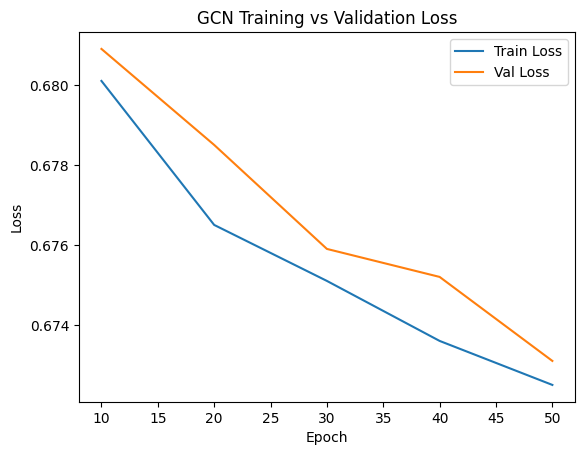

<Figure size 640x480 with 0 Axes>

In [91]:
import matplotlib.pyplot as plt

plt.plot(range(10, 51, 10), [0.6801, 0.6765, 0.6751, 0.6736, 0.6725], label='Train Loss')
plt.plot(range(10, 51, 10), [0.6809, 0.6785, 0.6759, 0.6752, 0.6731], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GCN Training vs Validation Loss')
plt.legend()
plt.show()
plt.savefig('/kaggle/working/graph14.png')



In [92]:
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
import torch
import torch.nn.functional as F

def evaluate_gcn(model, x, edge_index, y, mask):
    """
    Evaluate GCN model on a given mask.
    mask: boolean tensor of shape [num_nodes]
    """
    model.eval()
    data = Data(x=x, edge_index=edge_index, y=y)
    
    with torch.no_grad():
        out = model(data)
        
        # Ensure mask is boolean
        mask = mask.bool()
        
        # Predicted class
        _, preds = out[mask].max(dim=1)
        
        # Probabilities for ROC-AUC and PR-AUC
        probs = F.softmax(out[mask], dim=1)[:, 1].cpu().numpy()
        y_true = y[mask].cpu().numpy()
        
        # Handle cases where only one class is present
        try:
            roc = roc_auc_score(y_true, probs)
        except ValueError:
            roc = float('nan')
        try:
            pr = average_precision_score(y_true, probs)
        except ValueError:
            pr = float('nan')
        
        metrics = {
            'accuracy': accuracy_score(y_true, preds.cpu().numpy()),
            'f1_score': f1_score(y_true, preds.cpu().numpy(), average='weighted'),
            'roc_auc': roc,
            'pr_auc': pr
        }
    return metrics

# Example: create boolean masks of proper length
num_nodes = X_nodes_full.size(0)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[:X_train_nodes.size(0)] = True
val_mask[X_train_nodes.size(0):X_train_nodes.size(0)+X_val_nodes.size(0)] = True
test_mask[X_train_nodes.size(0)+X_val_nodes.size(0):] = True

# Evaluate
train_metrics = evaluate_gcn(model, X_nodes_full, edge_index, y_nodes_full, train_mask)
val_metrics   = evaluate_gcn(model, X_nodes_full, edge_index, y_nodes_full, val_mask)
test_metrics  = evaluate_gcn(model, X_nodes_full, edge_index, y_nodes_full, test_mask)

# Print
print(" Metrics:")
print(f"Train — Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1_score']:.4f}, "
      f"ROC-AUC: {train_metrics['roc_auc']:.4f}, PR-AUC: {train_metrics['pr_auc']:.4f}")
print(f"Val   — Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1_score']:.4f}, "
      f"ROC-AUC: {val_metrics['roc_auc']:.4f}, PR-AUC: {val_metrics['pr_auc']:.4f}")
print(f"Test  — Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1_score']:.4f}, "
      f"ROC-AUC: {test_metrics['roc_auc']:.4f}, PR-AUC: {test_metrics['pr_auc']:.4f}")


 Metrics:
Train — Acc: 0.7109, F1: 0.7092, ROC-AUC: 0.8032, PR-AUC: 0.8224
Val   — Acc: 0.7105, F1: 0.7089, ROC-AUC: 0.8032, PR-AUC: 0.8254
Test  — Acc: 0.7097, F1: 0.7081, ROC-AUC: 0.8022, PR-AUC: 0.8224


In [93]:
# ✅ Save GCNmodel
model_path = "/kaggle/working/gcn_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/gcn_model.pth


GCN Model Architecture:
GCNModel(
  (conv1): GCNConv(7, 32)
  (conv2): GCNConv(32, 2)
)


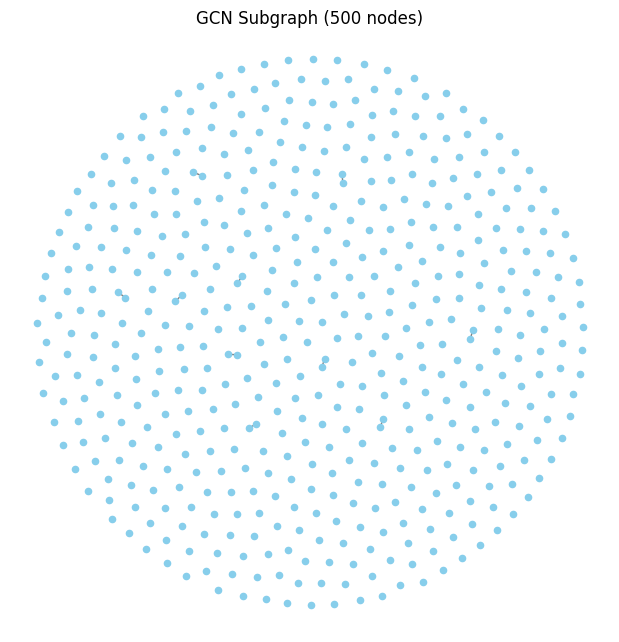

<Figure size 640x480 with 0 Axes>

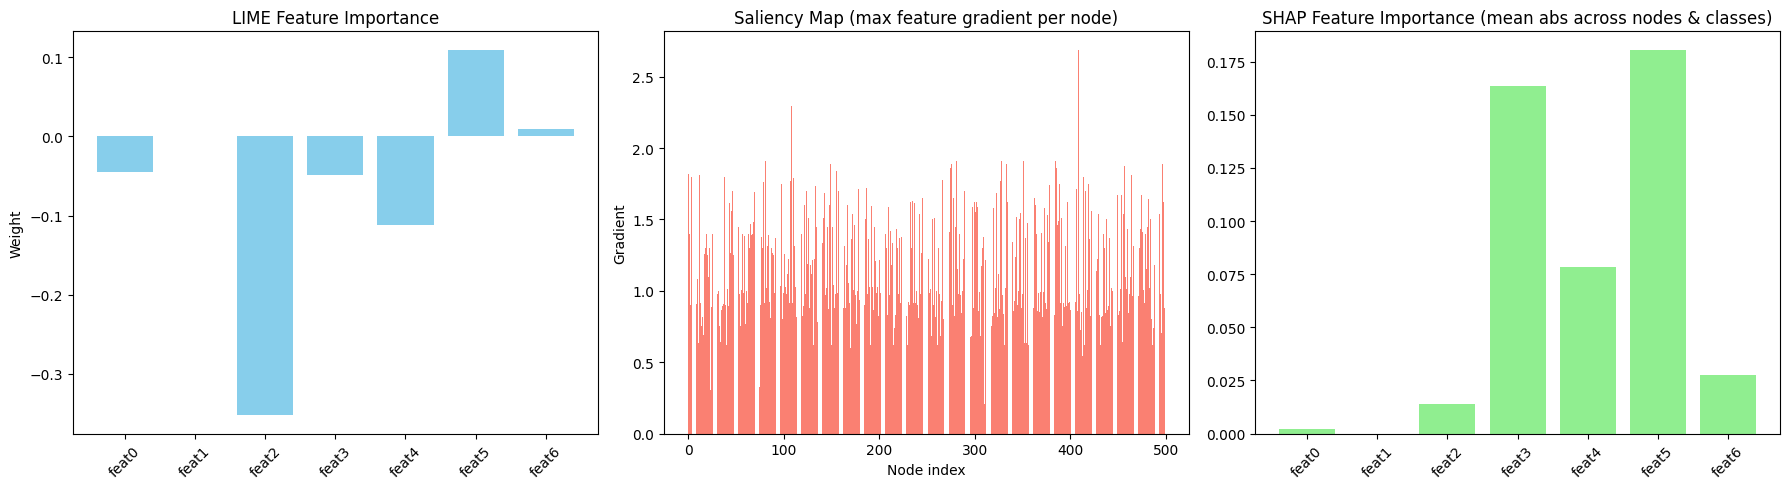

<Figure size 640x480 with 0 Axes>

In [94]:
# --- Imports ---
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, subgraph
import networkx as nx
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# --- 1️⃣ Display Architecture ---
print("GCN Model Architecture:")
print(model)

# --- 2️⃣ Subgraph Visualization ---
num_nodes_vis = min(500, X_nodes_full.size(0))
nodes_vis = torch.arange(num_nodes_vis)
edge_index_vis, _ = subgraph(nodes_vis, edge_index, relabel_nodes=True)
data_vis = Data(x=X_nodes_full[nodes_vis], edge_index=edge_index_vis)
G_vis = to_networkx(data_vis, to_undirected=True)

plt.figure(figsize=(6,6))
nx.draw(G_vis, node_size=20, node_color='skyblue', edge_color='gray')
plt.title(f"GCN Subgraph ({num_nodes_vis} nodes)")
plt.show()
plt.savefig('/kaggle/working/gcn_subgraph.png')

# --- 3️⃣ Prepare node features ---
X_sample = X_nodes_full[nodes_vis].cpu().numpy()

# --- 4️⃣ LIME Explainer ---
try:
    lime_explainer = LimeTabularExplainer(
        X_sample,
        feature_names=[f"feat{i}" for i in range(X_sample.shape[1])],
        class_names=['No Injury', 'Injury'],
        discretize_continuous=True
    )
    i = 0
    lime_exp = lime_explainer.explain_instance(
        X_sample[i],
        lambda x: F.softmax(
            model(Data(x=torch.tensor(x, dtype=torch.float, device=device),
                       edge_index=edge_index_vis)), dim=1
        ).detach().cpu().numpy()
    )
    lime_weights_corrected = {f"feat{i}":0 for i in range(X_sample.shape[1])}
    for feat_name, weight in lime_exp.as_list():
        idx = int(feat_name.split('feat')[1].split()[0])
        lime_weights_corrected[f"feat{idx}"] = weight
except Exception as e:
    print(f"LIME not supported: {e}")
    lime_weights_corrected = {f"feat{j}":0 for j in range(X_sample.shape[1])}

# --- 5️⃣ Saliency Map ---
try:
    X_tensor = X_nodes_full[nodes_vis].clone().detach().requires_grad_(True).to(device)
    output = model(Data(x=X_tensor, edge_index=edge_index_vis))
    target = output[:,1].sum()
    target.backward()
    saliency = X_tensor.grad.abs().max(dim=1)[0].detach().cpu().numpy()
except Exception as e:
    print(f"Saliency map not supported: {e}")
    saliency = np.zeros(num_nodes_vis)

# --- 6️⃣ SHAP Explainer ---
try:
    def gcn_wrapper(X_input):
        X_tensor = torch.tensor(X_input, dtype=torch.float, device=device)
        out = model(Data(x=X_tensor, edge_index=edge_index_vis))
        return F.softmax(out, dim=1).detach().cpu().numpy()
    
    shap_explainer = shap.Explainer(gcn_wrapper, X_sample)
    shap_values = shap_explainer(X_sample)
    
    # Aggregate across nodes and classes for plotting
    if shap_values.values.ndim == 3:
        # shape: (num_nodes, num_features, num_classes)
        mean_shap = np.mean(np.abs(shap_values.values), axis=(0,2))
    else:
        mean_shap = np.mean(np.abs(shap_values.values), axis=0)
except Exception as e:
    print(f"SHAP not supported: {e}")
    mean_shap = np.zeros(X_sample.shape[1])

# --- 7️⃣ Plot Dashboard ---
features = [f"feat{i}" for i in range(X_sample.shape[1])]
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# LIME
axes[0].bar(features, [lime_weights_corrected[f] for f in features], color='skyblue')
axes[0].set_title("LIME Feature Importance")
axes[0].set_ylabel("Weight")
axes[0].tick_params(axis='x', rotation=45)

# Saliency
axes[1].bar(range(num_nodes_vis), saliency, color='salmon')
axes[1].set_title("Saliency Map (max feature gradient per node)")
axes[1].set_xlabel("Node index")
axes[1].set_ylabel("Gradient")

# SHAP
axes[2].bar(features, mean_shap, color='lightgreen')
axes[2].set_title("SHAP Feature Importance (mean abs across nodes & classes)")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
plt.savefig('/kaggle/working/gcn_explainability_dashboard_fixed.png')


In [95]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [96]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

# -------------------------
# 1️⃣ Define the GraphSAGE model
# -------------------------
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# -------------------------
# 2️⃣ Training function
# -------------------------
def train_model(model, train_data, val_data, epochs=50, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    train_losses, val_losses = [], []
    
    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(train_data)
        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(val_data)
            val_loss = criterion(val_out, val_data.y)
            val_losses.append(val_loss.item())
        
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    return train_losses, val_losses

# -------------------------
# 3️⃣ Evaluation function
# -------------------------
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, preds = out.max(dim=1)
        y_true = data.y.cpu().numpy()
        probs = F.softmax(out, dim=1)[:, 1].cpu().numpy()
        
        metrics = {
            'accuracy': accuracy_score(y_true, preds.cpu().numpy()),
            'f1_score': f1_score(y_true, preds.cpu().numpy()),
            'roc_auc': roc_auc_score(y_true, probs),
            'pr_auc': average_precision_score(y_true, probs)
        }
    return metrics

# -------------------------
# 4️⃣ Set up model and train
# -------------------------
input_dim = train_data.num_node_features
hidden_dim = 32
output_dim = 2  # Assuming binary classification
dropout = 0.3

model = GraphSAGEModel(input_dim, hidden_dim, output_dim, dropout)
train_losses, val_losses = train_model(model, train_data, val_data, epochs=50, lr=0.01)

# -------------------------
# 5️⃣ Evaluate
# -------------------------
train_metrics = evaluate_model(model, train_data)
val_metrics   = evaluate_model(model, val_data)
test_metrics  = evaluate_model(model, test_data)

print("Metrics:")
print(f"Train — Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1_score']:.4f}, ROC-AUC: {train_metrics['roc_auc']:.4f}, PR-AUC: {train_metrics['pr_auc']:.4f}")
print(f"Val   — Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1_score']:.4f}, ROC-AUC: {val_metrics['roc_auc']:.4f}, PR-AUC: {val_metrics['pr_auc']:.4f}")
print(f"Test  — Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1_score']:.4f}, ROC-AUC: {test_metrics['roc_auc']:.4f}, PR-AUC: {test_metrics['pr_auc']:.4f}")


Epoch 1/50, Train Loss: 0.7073, Val Loss: 0.6785
Epoch 10/50, Train Loss: 0.6040, Val Loss: 0.5918
Epoch 20/50, Train Loss: 0.5614, Val Loss: 0.5490
Epoch 30/50, Train Loss: 0.5303, Val Loss: 0.5196
Epoch 40/50, Train Loss: 0.5024, Val Loss: 0.4942
Epoch 50/50, Train Loss: 0.4805, Val Loss: 0.4674
Metrics:
Train — Acc: 0.7760, F1: 0.7609, ROC-AUC: 0.8564, PR-AUC: 0.8743
Val   — Acc: 0.7767, F1: 0.7679, ROC-AUC: 0.8577, PR-AUC: 0.8743
Test  — Acc: 0.7743, F1: 0.7540, ROC-AUC: 0.8551, PR-AUC: 0.8738


In [97]:
# Save GraphSAGEmodel
model_path = "/kaggle/working/graphsage_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/graphsage_model.pth


GraphSAGE Model Architecture:
GraphSAGEModel(
  (conv1): SAGEConv(7, 32, aggr=mean)
  (conv2): SAGEConv(32, 2, aggr=mean)
)


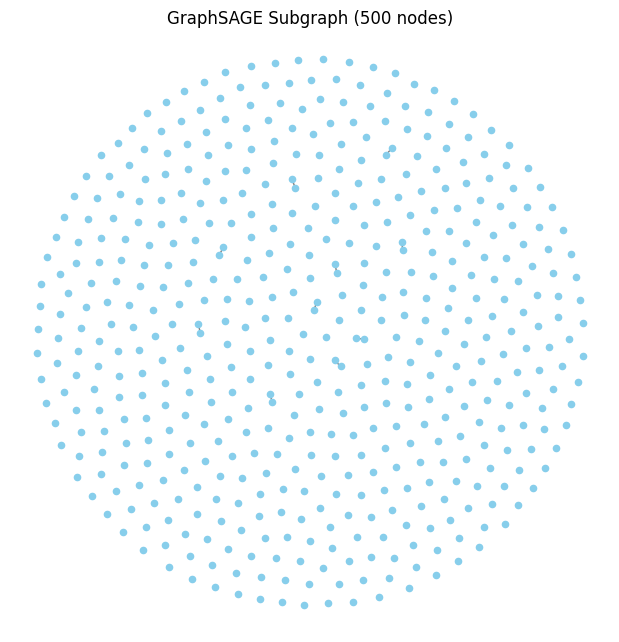

<Figure size 640x480 with 0 Axes>

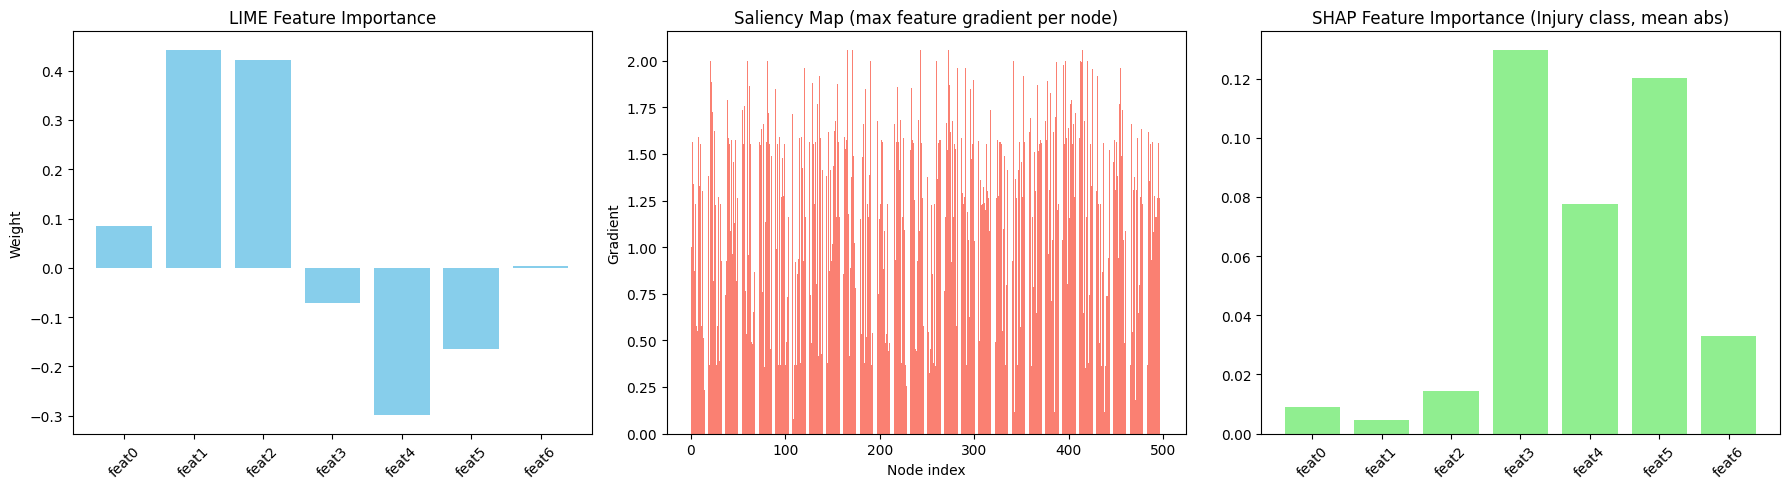

<Figure size 640x480 with 0 Axes>

In [100]:
# --- Imports ---
import torch
import torch.nn.functional as F
from torch_geometric.utils import to_networkx, subgraph
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# --- 1️⃣ Display Architecture ---
print("GraphSAGE Model Architecture:")
print(model)

# --- 2️⃣ Subgraph Visualization ---
num_nodes_vis = min(500, train_data.x.size(0))
nodes_vis = torch.arange(num_nodes_vis)
edge_index_vis, _ = subgraph(nodes_vis, train_data.edge_index, relabel_nodes=True)
data_vis = Data(x=train_data.x[nodes_vis], edge_index=edge_index_vis)
G_vis = to_networkx(data_vis, to_undirected=True)

plt.figure(figsize=(6,6))
nx.draw(G_vis, node_size=20, node_color='skyblue', edge_color='gray')
plt.title(f"GraphSAGE Subgraph ({num_nodes_vis} nodes)")
plt.show()
plt.savefig('/kaggle/working/graphsage_subgraph.png')

# --- 3️⃣ Prepare node features for explainability ---
X_sample = train_data.x[nodes_vis].cpu().numpy()

# --- 4️⃣ LIME Explainer ---
try:
    lime_explainer = LimeTabularExplainer(
        X_sample,
        feature_names=[f"feat{i}" for i in range(X_sample.shape[1])],
        class_names=['No Injury', 'Injury'],
        discretize_continuous=True
    )
    i = 0  # explain first node
    lime_exp = lime_explainer.explain_instance(
        X_sample[i],
        lambda x: F.softmax(
            model(Data(x=torch.tensor(x, dtype=torch.float, device=device),
                       edge_index=edge_index_vis)), dim=1
        ).detach().cpu().numpy()
    )
    
    # Process LIME weights
    lime_exp_list = lime_exp.as_list()
    lime_weights_corrected = {f"feat{i}":0 for i in range(X_sample.shape[1])}
    for feat_name, weight in lime_exp_list:
        idx = int(feat_name.split('feat')[1].split()[0])
        lime_weights_corrected[f"feat{idx}"] = weight
except Exception as e:
    print(f"LIME not supported: {e}")
    lime_weights_corrected = {f"feat{i}":0 for i in range(X_sample.shape[1])}

# --- 5️⃣ Saliency Map ---
try:
    X_tensor = train_data.x[nodes_vis].clone().detach().requires_grad_(True).to(device)
    output = model(Data(x=X_tensor, edge_index=edge_index_vis))
    target = output[:,1].sum()  # focus on Injury class
    target.backward()
    saliency = X_tensor.grad.abs().max(dim=1)[0].detach().cpu().numpy()
except Exception as e:
    print(f"Saliency map not supported: {e}")
    saliency = np.zeros(num_nodes_vis)

# --- 6️⃣ SHAP Explainer ---
try:
    def gcn_wrapper(X_input):
        X_tensor = torch.tensor(X_input, dtype=torch.float, device=device)
        out = model(Data(x=X_tensor, edge_index=edge_index_vis))
        return F.softmax(out, dim=1).detach().cpu().numpy()
    
    shap_explainer = shap.Explainer(gcn_wrapper, X_sample)
    shap_values = shap_explainer(X_sample)
    
    # --- FIX: Select class 1 (Injury) ---
    if shap_values.values.ndim == 3:  # shape: (num_samples, num_features, num_classes)
        mean_shap = np.mean(np.abs(shap_values.values[:,:,1]), axis=0)
    else:
        mean_shap = np.mean(np.abs(shap_values.values), axis=0)
except Exception as e:
    print(f"SHAP not supported: {e}")
    mean_shap = np.zeros(X_sample.shape[1])

# --- 7️⃣ Plot Explainability Dashboard ---
features = [f"feat{i}" for i in range(X_sample.shape[1])]
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# LIME
axes[0].bar(features, [lime_weights_corrected[f] for f in features], color='skyblue')
axes[0].set_title("LIME Feature Importance")
axes[0].set_ylabel("Weight")
axes[0].tick_params(axis='x', rotation=45)

# Saliency
axes[1].bar(range(num_nodes_vis), saliency, color='salmon')
axes[1].set_title("Saliency Map (max feature gradient per node)")
axes[1].set_xlabel("Node index")
axes[1].set_ylabel("Gradient")

# SHAP
axes[2].bar(features, mean_shap, color='lightgreen')
axes[2].set_title("SHAP Feature Importance (Injury class, mean abs)")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
plt.savefig('/kaggle/working/graphsage_explainability_dashboard.png')


In [101]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# Define the GAT model
class GATModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4, dropout=0.3):
        super(GATModel, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim*heads, output_dim, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x

# Hyperparameters
input_dim = train_data.x.shape[1]
hidden_dim = 32
output_dim = 2  # assuming binary classification

# Instantiate model
gat_model = GATModel(input_dim, hidden_dim, output_dim)

# Optimizer
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)

# Loss function
criterion = torch.nn.CrossEntropyLoss()


In [103]:
num_nodes = train_data.num_nodes  # 55458

# Initialize masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)

# Only train + val are possible (fit within num_nodes)
train_idx = torch.arange(0, X_train_nodes.shape[0])                # 0 → 55458
val_idx   = torch.arange(X_train_nodes.shape[0], num_nodes)        # 55458 → 55458 (empty)

# Test set cannot exist in current Data object
test_idx = torch.tensor([], dtype=torch.long)

# Set masks
train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True  # empty

# Attach to Data object
train_data.train_mask = train_mask
train_data.val_mask   = val_mask
train_data.test_mask  = test_mask

print("✅ Masks created and attached to Data object")
print(f"Train nodes: {train_mask.sum().item()}, Val nodes: {val_mask.sum().item()}, Test nodes: {test_mask.sum().item()}")


✅ Masks created and attached to Data object
Train nodes: 55458, Val nodes: 0, Test nodes: 0


In [104]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph

# --- 1. Combine all nodes ---
X_all = torch.cat([X_train_nodes, X_val_nodes, X_test_nodes], dim=0)  # [num_nodes, num_features]
y_all = torch.cat([y_train_nodes, y_val_nodes, y_test_nodes], dim=0)  # [num_nodes]

num_nodes = X_all.shape[0]

# --- 2. Build k-NN graph for all nodes ---
k = 10  # adjust k to match your previous setup
edge_index_all = knn_graph(X_all, k=k)  # [2, num_edges]

# --- 3. Create masks ---
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)

# Compute cumulative indices
train_mask[:X_train_nodes.shape[0]] = True
val_mask[X_train_nodes.shape[0]: X_train_nodes.shape[0] + X_val_nodes.shape[0]] = True
test_mask[X_train_nodes.shape[0] + X_val_nodes.shape[0]:] = True

# --- 4. Create Data object ---
data_all = Data(x=X_all, edge_index=edge_index_all, y=y_all)
data_all.train_mask = train_mask
data_all.val_mask   = val_mask
data_all.test_mask  = test_mask

print(" Data object ready for training:")
print(f"Nodes: {num_nodes}")
print(f"Train nodes: {train_mask.sum().item()}, Val nodes: {val_mask.sum().item()}, Test nodes: {test_mask.sum().item()}")
print(f"Edge index shape: {edge_index_all.shape}")


 Data object ready for training:
Nodes: 92430
Train nodes: 55458, Val nodes: 18486, Test nodes: 18486
Edge index shape: torch.Size([2, 924391])


In [105]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

# --- 1. GAT model definition ---
class GATModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=1, dropout=0.3):
        super(GATModel, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x

# --- 2. Training function ---
def train_gat(model, data, epochs=50, lr=0.005, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()
    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation loss
        model.eval()
        with torch.no_grad():
            out_val = model(data)
            val_loss = criterion(out_val[data.val_mask], data.y[data.val_mask])

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    return train_losses, val_losses

# --- 3. Evaluation function ---
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

def evaluate_gat(model, data, mask_name):
    model.eval()
    mask = getattr(data, mask_name)
    with torch.no_grad():
        out = model(data)
        _, preds = out[mask].max(dim=1)
        y_true = data.y[mask].cpu().numpy()
        probs = F.softmax(out[mask], dim=1)[:, 1].cpu().numpy()

        metrics = {
            'accuracy': accuracy_score(y_true, preds.cpu().numpy()),
            'f1': f1_score(y_true, preds.cpu().numpy()),
            'roc_auc': roc_auc_score(y_true, probs),
            'pr_auc': average_precision_score(y_true, probs)
        }
    return metrics

# --- 4. Example usage ---

# Make sure your Data object is 'data_all' with masks attached
input_dim = data_all.x.shape[1]
hidden_dim = 16
output_dim = len(torch.unique(data_all.y))  # e.g., 2 for binary classification

gat_model = GATModel(input_dim, hidden_dim, output_dim, heads=2, dropout=0.3)

# Train
train_losses, val_losses = train_gat(gat_model, data_all, epochs=50, lr=0.005)

# Evaluate
train_metrics = evaluate_gat(gat_model, data_all, 'train_mask')
val_metrics   = evaluate_gat(gat_model, data_all, 'val_mask')
test_metrics  = evaluate_gat(gat_model, data_all, 'test_mask')

# Print metrics
print(" Metrics:")
print(f"Train — Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1']:.4f}, "
      f"ROC-AUC: {train_metrics['roc_auc']:.4f}, PR-AUC: {train_metrics['pr_auc']:.4f}")
print(f"Val   — Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}, "
      f"ROC-AUC: {val_metrics['roc_auc']:.4f}, PR-AUC: {val_metrics['pr_auc']:.4f}")
print(f"Test  — Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1']:.4f}, "
      f"ROC-AUC: {test_metrics['roc_auc']:.4f}, PR-AUC: {test_metrics['pr_auc']:.4f}")


Epoch 1/50, Train Loss: 0.8539, Val Loss: 0.7580
Epoch 10/50, Train Loss: 0.6428, Val Loss: 0.6214
Epoch 20/50, Train Loss: 0.5853, Val Loss: 0.5785
Epoch 30/50, Train Loss: 0.5718, Val Loss: 0.5692
Epoch 40/50, Train Loss: 0.5663, Val Loss: 0.5662
Epoch 50/50, Train Loss: 0.5611, Val Loss: 0.5627
 Metrics:
Train — Acc: 0.7164, F1: 0.7105, ROC-AUC: 0.7816, PR-AUC: 0.7886
Val   — Acc: 0.7157, F1: 0.7083, ROC-AUC: 0.7795, PR-AUC: 0.7857
Test  — Acc: 0.7152, F1: 0.7083, ROC-AUC: 0.7805, PR-AUC: 0.7870


In [106]:
#  Save GATmodel
model_path = "/kaggle/working/gat_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/gat_model.pth


GAT Model Architecture:
GATModel(
  (gat1): GATConv(7, 16, heads=2)
  (gat2): GATConv(32, 2, heads=1)
)


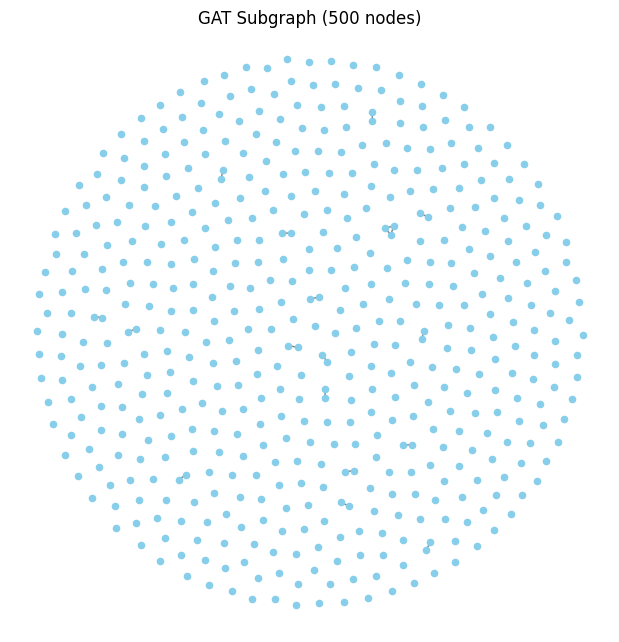

<Figure size 640x480 with 0 Axes>

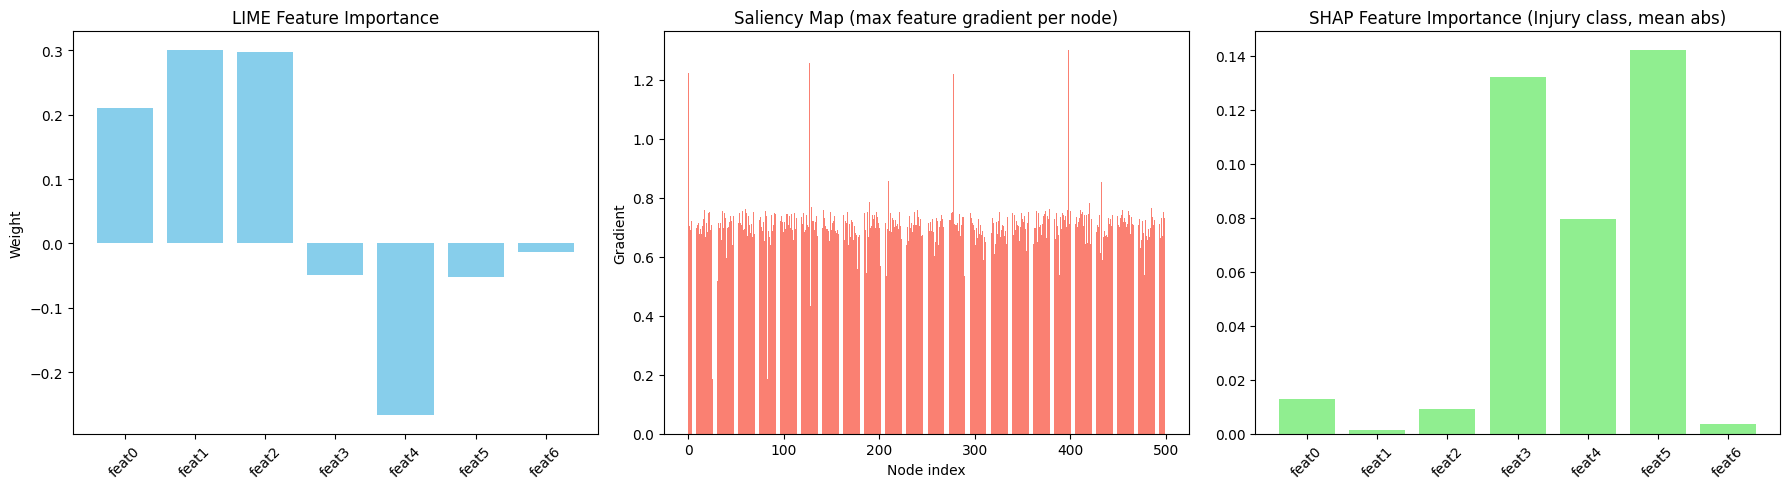

<Figure size 640x480 with 0 Axes>

In [107]:
# --- Imports ---
import torch
import torch.nn.functional as F
from torch_geometric.utils import to_networkx, subgraph
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# --- 1️⃣ Display Architecture ---
print("GAT Model Architecture:")
print(gat_model)

# --- 2️⃣ Subgraph Visualization ---
num_nodes_vis = min(500, data_all.x.size(0))
nodes_vis = torch.arange(num_nodes_vis)
edge_index_vis, _ = subgraph(nodes_vis, data_all.edge_index, relabel_nodes=True)
data_vis = Data(x=data_all.x[nodes_vis], edge_index=edge_index_vis)
G_vis = to_networkx(data_vis, to_undirected=True)

plt.figure(figsize=(6,6))
nx.draw(G_vis, node_size=20, node_color='skyblue', edge_color='gray')
plt.title(f"GAT Subgraph ({num_nodes_vis} nodes)")
plt.show()
plt.savefig('/kaggle/working/gat_subgraph.png')

# --- 3️⃣ Prepare node features for explainability ---
X_sample = data_all.x[nodes_vis].cpu().numpy()

# --- 4️⃣ LIME Explainer ---
try:
    lime_explainer = LimeTabularExplainer(
        X_sample,
        feature_names=[f"feat{i}" for i in range(X_sample.shape[1])],
        class_names=['No Injury', 'Injury'],
        discretize_continuous=True
    )
    i = 0  # first node
    lime_exp = lime_explainer.explain_instance(
        X_sample[i],
        lambda x: F.softmax(
            gat_model(Data(x=torch.tensor(x, dtype=torch.float, device=device),
                           edge_index=edge_index_vis)), dim=1
        ).detach().cpu().numpy()
    )
    
    # Process LIME weights
    lime_exp_list = lime_exp.as_list()
    lime_weights_corrected = {f"feat{i}":0 for i in range(X_sample.shape[1])}
    for feat_name, weight in lime_exp_list:
        idx = int(feat_name.split('feat')[1].split()[0])
        lime_weights_corrected[f"feat{idx}"] = weight
except Exception as e:
    print(f"LIME not supported: {e}")
    lime_weights_corrected = {f"feat{i}":0 for i in range(X_sample.shape[1])}

# --- 5️⃣ Saliency Map ---
try:
    X_tensor = data_all.x[nodes_vis].clone().detach().requires_grad_(True).to(device)
    output = gat_model(Data(x=X_tensor, edge_index=edge_index_vis))
    target = output[:,1].sum()  # focus on Injury class
    target.backward()
    saliency = X_tensor.grad.abs().max(dim=1)[0].detach().cpu().numpy()
except Exception as e:
    print(f"Saliency map not supported: {e}")
    saliency = np.zeros(num_nodes_vis)

# --- 6️⃣ SHAP Explainer ---
try:
    def gat_wrapper(X_input):
        X_tensor = torch.tensor(X_input, dtype=torch.float, device=device)
        out = gat_model(Data(x=X_tensor, edge_index=edge_index_vis))
        return F.softmax(out, dim=1).detach().cpu().numpy()
    
    shap_explainer = shap.Explainer(gat_wrapper, X_sample)
    shap_values = shap_explainer(X_sample)
    
    # Select class 1 (Injury)
    if shap_values.values.ndim == 3:
        mean_shap = np.mean(np.abs(shap_values.values[:,:,1]), axis=0)
    else:
        mean_shap = np.mean(np.abs(shap_values.values), axis=0)
except Exception as e:
    print(f"SHAP not supported: {e}")
    mean_shap = np.zeros(X_sample.shape[1])

# --- 7️⃣ Plot Explainability Dashboard ---
features = [f"feat{i}" for i in range(X_sample.shape[1])]
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# LIME
axes[0].bar(features, [lime_weights_corrected[f] for f in features], color='skyblue')
axes[0].set_title("LIME Feature Importance")
axes[0].set_ylabel("Weight")
axes[0].tick_params(axis='x', rotation=45)

# Saliency
axes[1].bar(range(num_nodes_vis), saliency, color='salmon')
axes[1].set_title("Saliency Map (max feature gradient per node)")
axes[1].set_xlabel("Node index")
axes[1].set_ylabel("Gradient")

# SHAP
axes[2].bar(features, mean_shap, color='lightgreen')
axes[2].set_title("SHAP Feature Importance (Injury class, mean abs)")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
plt.savefig('/kaggle/working/gat_explainability_dashboard.png')


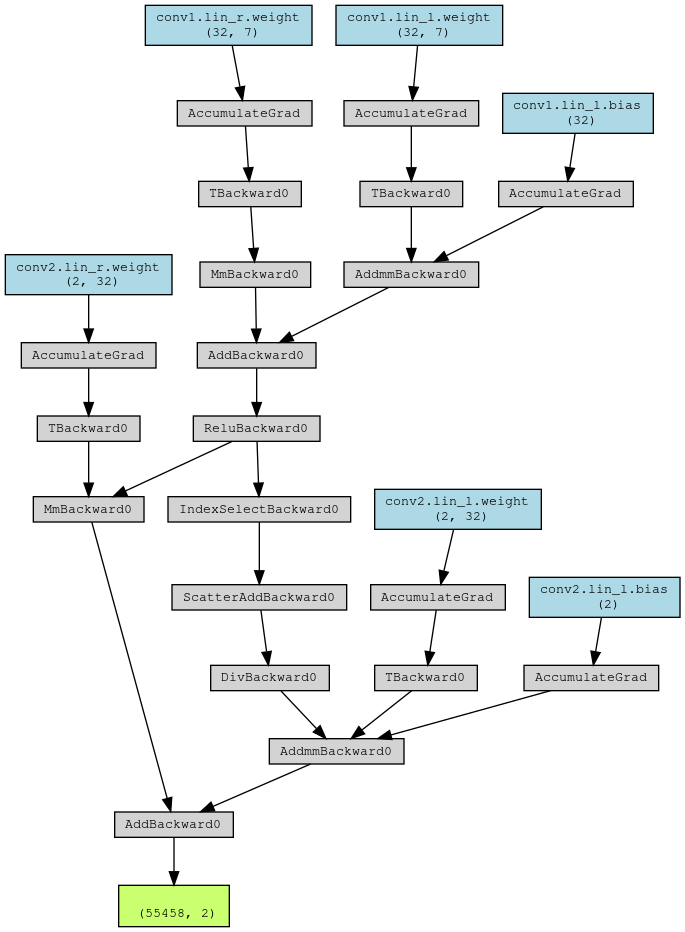

In [108]:
# Install torchviz if not already installed
!pip install torchviz

from torchviz import make_dot

# Example: visualizing GCN forward pass
model.eval()
out = model(train_data)  # forward pass with your Data object

# Make graph
dot = make_dot(out, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('gcn_model_architecture')  # saves 'gcn_model_architecture.png'

# Display in Kaggle
from IPython.display import Image
Image('gcn_model_architecture.png')

